In [1]:
import os
import cv2
import torch
import helper
import time
from tqdm import tqdm
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
import torchvision
import matplotlib.pyplot as plt

In [2]:
# define the path to the images and masks dataset
image_dataset_path = "dataset\\images"
mask_dataset_path = "dataset\\masks"

# define the test split
test_split = 0.15

# determine the device to be used for training and evaluation
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.backends.cudnn.benchmark = True

#initialize learning rate, number of epochs to train for, and the batch size
init_lr = 1e-4
num_epochs = 500
batch_size = 5

# define the input image dimensions
input_image_width = 400
input_image_height = 400

# define the path to the base output directory
base_output = "output"

# define the path to the output serialized model, model training plot, and testing image paths
model_path = os.path.join(base_output, "unet_model.pth")
plot_path = os.path.sep.join([base_output, "plot.png"])
test_paths = os.path.sep.join([base_output, "test_paths.txt"])

In [3]:
# load the image and mask filepaths in a sorted manner
imagePaths = os.listdir(image_dataset_path)
maskPaths = os.listdir(mask_dataset_path)
imageprefix = image_dataset_path + "\\"
maskprefix = mask_dataset_path + "\\"
imagePaths = [imageprefix + x for x in imagePaths]
maskPaths = [maskprefix + x for x in maskPaths]
# partition the data into training and testing splits using 85% of the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths, test_size=test_split, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]
# write the testing image paths to disk so that we can use then when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open(test_paths, "w")
f.write("\n".join(testImages))
f.close()

[INFO] saving testing image paths...


In [4]:
class SegmentationDataset(Dataset):
    def __init__(self, imagePaths, maskPaths, image_transforms, mask_transforms):
        # store the image and mask filepaths, and augmentation transforms
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms
    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.imagePaths)
    def __getitem__(self, idx):
        img_path = self.imagePaths[idx]
        mask_path = self.maskPaths[idx]
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        if self.image_transforms is not None:
            image = self.image_transforms(image)
        if self.mask_transforms is not None:
            mask = self.mask_transforms(mask)
        return (image, mask)

In [5]:
# define transformations
image_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0., 0., 0.], 
                                                            [1., 1., 1.])]) 

mask_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.], 
                                                            [1.])])

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks,
    image_transforms=image_transforms, mask_transforms=mask_transforms)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks,
    image_transforms=image_transforms, mask_transforms=mask_transforms)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True, batch_size=batch_size, pin_memory = True if device == "cuda" else False)
testLoader = DataLoader(testDS, shuffle=False, batch_size=batch_size, pin_memory= True if device == "cuda" else False)

[INFO] found 188 examples in the training set...
[INFO] found 34 examples in the test set...


In [6]:
# Run this to test your data loader
(images, masks) = next(iter(trainLoader))

In [7]:
print(f'x = shape: {images.shape}; type: {images.dtype}')
print(f'y = shape: {masks.shape}; type: {masks.dtype}')
print(f'x = min: {images.min()}; max: {images.max()}')
print(f'y = min: {masks.min()}; max: {masks.max()}')

x = shape: torch.Size([5, 3, 400, 400]); type: torch.float32
y = shape: torch.Size([5, 1, 400, 400]); type: torch.float32
x = min: 0.0; max: 0.9333333373069763
y = min: 0.0; max: 0.7254902124404907


<AxesSubplot:>

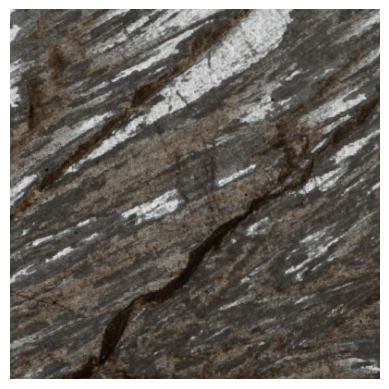

In [8]:
helper.imshow(images[0], normalize=False)

<AxesSubplot:>

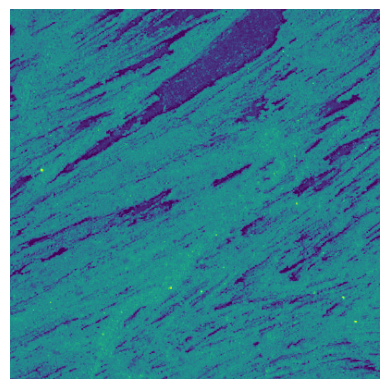

In [9]:
helper.imshow(masks[0], normalize=False)

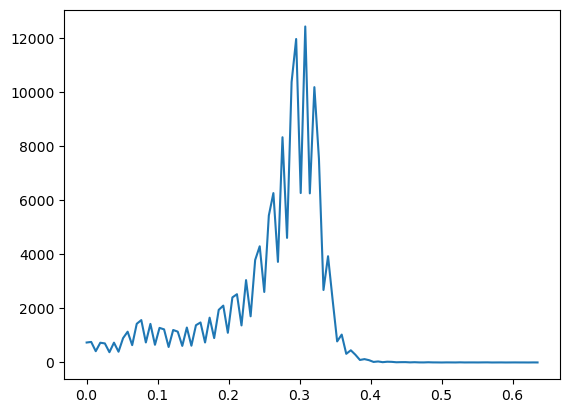

In [10]:
hist = masks[0].histc()
masks_min = masks[0].min().item()
masks_max = masks[0].max().item()
plt.plot(torch.linspace(masks_min, masks_max, len(hist)), hist)
plt.show()

In [11]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(
        self, in_channels=3, out_channels=1, features=[16, 32, 64, 128],
    ):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # make sure the input is dividable by 16
        
        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
            
        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
            
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
    
    def forward(self, x):
        skip_connections = []
        
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
            
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            
            # to solve the problem of input not dividable by 16
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
                
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
            
        return self.final_conv(x)

In [12]:
# initialize our UNet model
unet = UNet().to(device)
# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss() # change to cross entropy loss for multi class
opt = Adam(unet.parameters(), lr=init_lr)
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // batch_size
testSteps = len(testDS) // batch_size
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [13]:
pred = unet(images.to(device))

In [14]:
loss = lossFunc(pred, masks.to(device))
print(loss)

tensor(0.6681, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [15]:
new_pred = pred.cpu()

In [16]:
new_pred = torch.sigmoid(new_pred)

<AxesSubplot:>

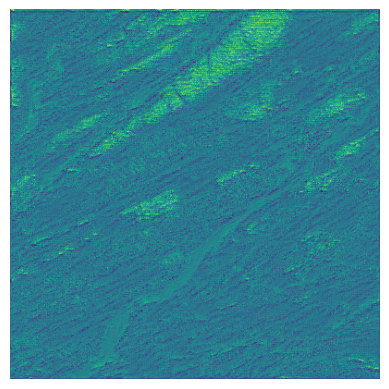

In [17]:
helper.imshow(new_pred[0].detach(), normalize=False)

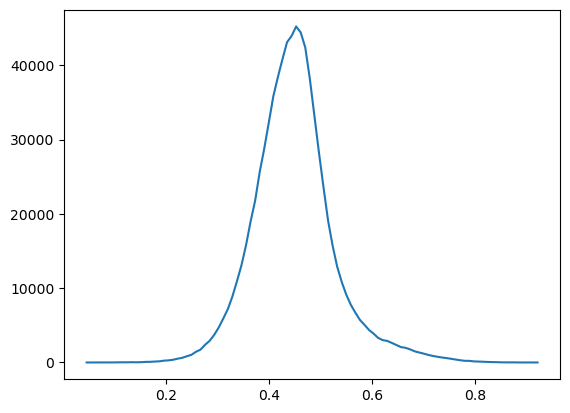

In [18]:
hist = new_pred.histc()
new_pred_min = new_pred.min().item()
new_pred_max = new_pred.max().item()
plt.plot(torch.linspace(new_pred_min, new_pred_max, len(hist)), hist)
plt.show()

[INFO] training the network...


  0%|▏                                                                               | 1/500 [00:29<4:06:21, 29.62s/it]

[INFO] EPOCH: 1/500
Train loss: 0.659288, Test loss: 0.7370


  0%|▎                                                                               | 2/500 [00:59<4:05:14, 29.55s/it]

[INFO] EPOCH: 2/500
Train loss: 0.634860, Test loss: 0.7133


  1%|▍                                                                               | 3/500 [01:45<5:06:37, 37.02s/it]

[INFO] EPOCH: 3/500
Train loss: 0.620518, Test loss: 0.7059


  1%|▋                                                                               | 4/500 [02:11<4:32:03, 32.91s/it]

[INFO] EPOCH: 4/500
Train loss: 0.609603, Test loss: 0.6909


  1%|▊                                                                               | 5/500 [02:41<4:21:45, 31.73s/it]

[INFO] EPOCH: 5/500
Train loss: 0.602596, Test loss: 0.6871


  1%|▉                                                                               | 6/500 [03:27<5:02:13, 36.71s/it]

[INFO] EPOCH: 6/500
Train loss: 0.598127, Test loss: 0.6850


  1%|█                                                                               | 7/500 [03:55<4:37:55, 33.82s/it]

[INFO] EPOCH: 7/500
Train loss: 0.594878, Test loss: 0.6781


  2%|█▎                                                                              | 8/500 [04:31<4:42:08, 34.41s/it]

[INFO] EPOCH: 8/500
Train loss: 0.592606, Test loss: 0.6769


  2%|█▍                                                                              | 9/500 [05:11<4:56:46, 36.26s/it]

[INFO] EPOCH: 9/500
Train loss: 0.590484, Test loss: 0.6753


  2%|█▌                                                                             | 10/500 [05:35<4:26:09, 32.59s/it]

[INFO] EPOCH: 10/500
Train loss: 0.588563, Test loss: 0.6764


  2%|█▋                                                                             | 11/500 [06:12<4:36:06, 33.88s/it]

[INFO] EPOCH: 11/500
Train loss: 0.587203, Test loss: 0.6740


  2%|█▉                                                                             | 12/500 [06:37<4:13:28, 31.16s/it]

[INFO] EPOCH: 12/500
Train loss: 0.586020, Test loss: 0.6723


  3%|██                                                                             | 13/500 [07:15<4:28:45, 33.11s/it]

[INFO] EPOCH: 13/500
Train loss: 0.584850, Test loss: 0.6692


  3%|██▏                                                                            | 14/500 [07:59<4:55:35, 36.49s/it]

[INFO] EPOCH: 14/500
Train loss: 0.584373, Test loss: 0.6709


  3%|██▎                                                                            | 15/500 [08:20<4:18:09, 31.94s/it]

[INFO] EPOCH: 15/500
Train loss: 0.582261, Test loss: 0.6694


  3%|██▌                                                                            | 16/500 [09:02<4:41:45, 34.93s/it]

[INFO] EPOCH: 16/500
Train loss: 0.582216, Test loss: 0.6690


  3%|██▋                                                                            | 17/500 [09:34<4:32:21, 33.83s/it]

[INFO] EPOCH: 17/500
Train loss: 0.581784, Test loss: 0.6660


  4%|██▊                                                                            | 18/500 [10:06<4:27:08, 33.25s/it]

[INFO] EPOCH: 18/500
Train loss: 0.580080, Test loss: 0.6696


  4%|███                                                                            | 19/500 [10:56<5:08:10, 38.44s/it]

[INFO] EPOCH: 19/500
Train loss: 0.580108, Test loss: 0.6680


  4%|███▏                                                                           | 20/500 [11:39<5:17:53, 39.74s/it]

[INFO] EPOCH: 20/500
Train loss: 0.579461, Test loss: 0.6662


  4%|███▎                                                                           | 21/500 [12:08<4:51:31, 36.52s/it]

[INFO] EPOCH: 21/500
Train loss: 0.578980, Test loss: 0.6670


  4%|███▍                                                                           | 22/500 [12:41<4:42:22, 35.44s/it]

[INFO] EPOCH: 22/500
Train loss: 0.579201, Test loss: 0.6661


  5%|███▋                                                                           | 23/500 [13:17<4:44:28, 35.78s/it]

[INFO] EPOCH: 23/500
Train loss: 0.578796, Test loss: 0.6645


  5%|███▊                                                                           | 24/500 [13:41<4:15:17, 32.18s/it]

[INFO] EPOCH: 24/500
Train loss: 0.578333, Test loss: 0.6646


  5%|███▉                                                                           | 25/500 [14:24<4:41:13, 35.52s/it]

[INFO] EPOCH: 25/500
Train loss: 0.578169, Test loss: 0.6647


  5%|████                                                                           | 26/500 [14:58<4:36:38, 35.02s/it]

[INFO] EPOCH: 26/500
Train loss: 0.578133, Test loss: 0.6646


  5%|████▎                                                                          | 27/500 [15:25<4:16:47, 32.57s/it]

[INFO] EPOCH: 27/500
Train loss: 0.578454, Test loss: 0.6653


  6%|████▍                                                                          | 28/500 [16:02<4:25:56, 33.81s/it]

[INFO] EPOCH: 28/500
Train loss: 0.577937, Test loss: 0.6644


  6%|████▌                                                                          | 29/500 [16:23<3:55:55, 30.05s/it]

[INFO] EPOCH: 29/500
Train loss: 0.577408, Test loss: 0.6653


  6%|████▋                                                                          | 30/500 [16:59<4:09:55, 31.91s/it]

[INFO] EPOCH: 30/500
Train loss: 0.577659, Test loss: 0.6638


  6%|████▉                                                                          | 31/500 [17:34<4:15:38, 32.70s/it]

[INFO] EPOCH: 31/500
Train loss: 0.577527, Test loss: 0.6640


  6%|█████                                                                          | 32/500 [18:09<4:20:37, 33.41s/it]

[INFO] EPOCH: 32/500
Train loss: 0.577505, Test loss: 0.6638


  7%|█████▏                                                                         | 33/500 [18:45<4:26:22, 34.22s/it]

[INFO] EPOCH: 33/500
Train loss: 0.576790, Test loss: 0.6646


  7%|█████▎                                                                         | 34/500 [19:11<4:05:45, 31.64s/it]

[INFO] EPOCH: 34/500
Train loss: 0.576957, Test loss: 0.6641


  7%|█████▌                                                                         | 35/500 [19:58<4:40:49, 36.23s/it]

[INFO] EPOCH: 35/500
Train loss: 0.577280, Test loss: 0.6635


  7%|█████▋                                                                         | 36/500 [20:30<4:31:36, 35.12s/it]

[INFO] EPOCH: 36/500
Train loss: 0.577627, Test loss: 0.6640


  7%|█████▊                                                                         | 37/500 [21:07<4:34:54, 35.62s/it]

[INFO] EPOCH: 37/500
Train loss: 0.577323, Test loss: 0.6635


  8%|██████                                                                         | 38/500 [21:49<4:48:12, 37.43s/it]

[INFO] EPOCH: 38/500
Train loss: 0.576412, Test loss: 0.6634


  8%|██████▏                                                                        | 39/500 [22:28<4:52:54, 38.12s/it]

[INFO] EPOCH: 39/500
Train loss: 0.576743, Test loss: 0.6634


  8%|██████▎                                                                        | 40/500 [23:06<4:50:38, 37.91s/it]

[INFO] EPOCH: 40/500
Train loss: 0.577155, Test loss: 0.6640


  8%|██████▍                                                                        | 41/500 [23:39<4:39:18, 36.51s/it]

[INFO] EPOCH: 41/500
Train loss: 0.576542, Test loss: 0.6634


  8%|██████▋                                                                        | 42/500 [24:07<4:20:08, 34.08s/it]

[INFO] EPOCH: 42/500
Train loss: 0.576530, Test loss: 0.6634


  9%|██████▊                                                                        | 43/500 [24:34<4:02:13, 31.80s/it]

[INFO] EPOCH: 43/500
Train loss: 0.576266, Test loss: 0.6635


  9%|██████▉                                                                        | 44/500 [25:16<4:25:48, 34.97s/it]

[INFO] EPOCH: 44/500
Train loss: 0.576268, Test loss: 0.6637


  9%|███████                                                                        | 45/500 [25:46<4:13:15, 33.40s/it]

[INFO] EPOCH: 45/500
Train loss: 0.575730, Test loss: 0.6639


  9%|███████▎                                                                       | 46/500 [26:23<4:20:36, 34.44s/it]

[INFO] EPOCH: 46/500
Train loss: 0.575997, Test loss: 0.6634


  9%|███████▍                                                                       | 47/500 [27:02<4:29:35, 35.71s/it]

[INFO] EPOCH: 47/500
Train loss: 0.576611, Test loss: 0.6635


 10%|███████▌                                                                       | 48/500 [27:26<4:02:57, 32.25s/it]

[INFO] EPOCH: 48/500
Train loss: 0.576948, Test loss: 0.6634


 10%|███████▋                                                                       | 49/500 [28:03<4:14:18, 33.83s/it]

[INFO] EPOCH: 49/500
Train loss: 0.576322, Test loss: 0.6632


 10%|███████▉                                                                       | 50/500 [28:28<3:52:24, 30.99s/it]

[INFO] EPOCH: 50/500
Train loss: 0.576106, Test loss: 0.6634


 10%|████████                                                                       | 51/500 [29:05<4:06:42, 32.97s/it]

[INFO] EPOCH: 51/500
Train loss: 0.576976, Test loss: 0.6636


 10%|████████▏                                                                      | 52/500 [29:32<3:51:37, 31.02s/it]

[INFO] EPOCH: 52/500
Train loss: 0.575821, Test loss: 0.6641


 11%|████████▎                                                                      | 53/500 [30:01<3:47:57, 30.60s/it]

[INFO] EPOCH: 53/500
Train loss: 0.576029, Test loss: 0.6631


 11%|████████▌                                                                      | 54/500 [30:38<4:01:28, 32.49s/it]

[INFO] EPOCH: 54/500
Train loss: 0.576260, Test loss: 0.6636


 11%|████████▋                                                                      | 55/500 [31:09<3:57:21, 32.00s/it]

[INFO] EPOCH: 55/500
Train loss: 0.576256, Test loss: 0.6636


 11%|████████▊                                                                      | 56/500 [31:49<4:14:40, 34.41s/it]

[INFO] EPOCH: 56/500
Train loss: 0.575818, Test loss: 0.6629


 11%|█████████                                                                      | 57/500 [32:18<4:03:01, 32.91s/it]

[INFO] EPOCH: 57/500
Train loss: 0.576140, Test loss: 0.6628


 12%|█████████▏                                                                     | 58/500 [32:46<3:51:05, 31.37s/it]

[INFO] EPOCH: 58/500
Train loss: 0.575757, Test loss: 0.6630


 12%|█████████▎                                                                     | 59/500 [33:22<3:59:08, 32.54s/it]

[INFO] EPOCH: 59/500
Train loss: 0.575885, Test loss: 0.6627


 12%|█████████▍                                                                     | 60/500 [33:56<4:03:56, 33.27s/it]

[INFO] EPOCH: 60/500
Train loss: 0.575622, Test loss: 0.6627


 12%|█████████▋                                                                     | 61/500 [34:35<4:13:56, 34.71s/it]

[INFO] EPOCH: 61/500
Train loss: 0.575871, Test loss: 0.6630


 12%|█████████▊                                                                     | 62/500 [35:11<4:17:48, 35.32s/it]

[INFO] EPOCH: 62/500
Train loss: 0.575300, Test loss: 0.6627


 13%|█████████▉                                                                     | 63/500 [35:43<4:10:09, 34.35s/it]

[INFO] EPOCH: 63/500
Train loss: 0.575708, Test loss: 0.6629


 13%|██████████                                                                     | 64/500 [36:23<4:20:09, 35.80s/it]

[INFO] EPOCH: 64/500
Train loss: 0.575489, Test loss: 0.6625


 13%|██████████▎                                                                    | 65/500 [37:00<4:23:00, 36.28s/it]

[INFO] EPOCH: 65/500
Train loss: 0.575205, Test loss: 0.6626


 13%|██████████▍                                                                    | 66/500 [37:23<3:53:47, 32.32s/it]

[INFO] EPOCH: 66/500
Train loss: 0.575238, Test loss: 0.6628


 13%|██████████▌                                                                    | 67/500 [38:08<4:21:02, 36.17s/it]

[INFO] EPOCH: 67/500
Train loss: 0.575845, Test loss: 0.6626


 14%|██████████▋                                                                    | 68/500 [38:34<3:57:28, 32.98s/it]

[INFO] EPOCH: 68/500
Train loss: 0.575731, Test loss: 0.6626


 14%|██████████▉                                                                    | 69/500 [39:08<3:59:57, 33.40s/it]

[INFO] EPOCH: 69/500
Train loss: 0.575106, Test loss: 0.6631


 14%|███████████                                                                    | 70/500 [39:46<4:08:14, 34.64s/it]

[INFO] EPOCH: 70/500
Train loss: 0.575482, Test loss: 0.6627


 14%|███████████▏                                                                   | 71/500 [40:15<3:55:52, 32.99s/it]

[INFO] EPOCH: 71/500
Train loss: 0.575293, Test loss: 0.6625


 14%|███████████▍                                                                   | 72/500 [40:55<4:10:50, 35.16s/it]

[INFO] EPOCH: 72/500
Train loss: 0.575682, Test loss: 0.6624


 15%|███████████▌                                                                   | 73/500 [41:28<4:04:52, 34.41s/it]

[INFO] EPOCH: 73/500
Train loss: 0.575190, Test loss: 0.6624


 15%|███████████▋                                                                   | 74/500 [42:00<4:00:41, 33.90s/it]

[INFO] EPOCH: 74/500
Train loss: 0.575516, Test loss: 0.6627


 15%|███████████▊                                                                   | 75/500 [42:44<4:20:11, 36.73s/it]

[INFO] EPOCH: 75/500
Train loss: 0.575406, Test loss: 0.6624


 15%|████████████                                                                   | 76/500 [43:12<4:02:00, 34.25s/it]

[INFO] EPOCH: 76/500
Train loss: 0.575174, Test loss: 0.6622


 15%|████████████▏                                                                  | 77/500 [43:41<3:49:43, 32.58s/it]

[INFO] EPOCH: 77/500
Train loss: 0.574781, Test loss: 0.6621


 16%|████████████▎                                                                  | 78/500 [44:18<3:57:53, 33.82s/it]

[INFO] EPOCH: 78/500
Train loss: 0.575155, Test loss: 0.6623


 16%|████████████▍                                                                  | 79/500 [44:41<3:36:06, 30.80s/it]

[INFO] EPOCH: 79/500
Train loss: 0.575215, Test loss: 0.6622


 16%|████████████▋                                                                  | 80/500 [45:19<3:49:22, 32.77s/it]

[INFO] EPOCH: 80/500
Train loss: 0.574204, Test loss: 0.6621


 16%|████████████▊                                                                  | 81/500 [45:47<3:39:56, 31.50s/it]

[INFO] EPOCH: 81/500
Train loss: 0.574506, Test loss: 0.6623


 16%|████████████▉                                                                  | 82/500 [46:24<3:50:02, 33.02s/it]

[INFO] EPOCH: 82/500
Train loss: 0.574899, Test loss: 0.6624


 17%|█████████████                                                                  | 83/500 [47:01<3:59:02, 34.39s/it]

[INFO] EPOCH: 83/500
Train loss: 0.574686, Test loss: 0.6622


 17%|█████████████▎                                                                 | 84/500 [47:23<3:32:31, 30.65s/it]

[INFO] EPOCH: 84/500
Train loss: 0.575156, Test loss: 0.6624


 17%|█████████████▍                                                                 | 85/500 [48:09<4:02:16, 35.03s/it]

[INFO] EPOCH: 85/500
Train loss: 0.575264, Test loss: 0.6622


 17%|█████████████▌                                                                 | 86/500 [48:39<3:53:03, 33.78s/it]

[INFO] EPOCH: 86/500
Train loss: 0.574809, Test loss: 0.6620


 17%|█████████████▋                                                                 | 87/500 [49:09<3:43:31, 32.47s/it]

[INFO] EPOCH: 87/500
Train loss: 0.574822, Test loss: 0.6620


 18%|█████████████▉                                                                 | 88/500 [49:46<3:53:34, 34.02s/it]

[INFO] EPOCH: 88/500
Train loss: 0.574595, Test loss: 0.6623


 18%|██████████████                                                                 | 89/500 [50:12<3:35:41, 31.49s/it]

[INFO] EPOCH: 89/500
Train loss: 0.574438, Test loss: 0.6623


 18%|██████████████▏                                                                | 90/500 [50:52<3:53:15, 34.14s/it]

[INFO] EPOCH: 90/500
Train loss: 0.574523, Test loss: 0.6620


 18%|██████████████▍                                                                | 91/500 [51:23<3:46:07, 33.17s/it]

[INFO] EPOCH: 91/500
Train loss: 0.574004, Test loss: 0.6620


 18%|██████████████▌                                                                | 92/500 [51:53<3:37:36, 32.00s/it]

[INFO] EPOCH: 92/500
Train loss: 0.574402, Test loss: 0.6620


 19%|██████████████▋                                                                | 93/500 [52:32<3:52:19, 34.25s/it]

[INFO] EPOCH: 93/500
Train loss: 0.574378, Test loss: 0.6619


 19%|██████████████▊                                                                | 94/500 [52:58<3:34:12, 31.66s/it]

[INFO] EPOCH: 94/500
Train loss: 0.574541, Test loss: 0.6618


 19%|███████████████                                                                | 95/500 [53:41<3:57:09, 35.13s/it]

[INFO] EPOCH: 95/500
Train loss: 0.574174, Test loss: 0.6622


 19%|███████████████▏                                                               | 96/500 [54:08<3:39:46, 32.64s/it]

[INFO] EPOCH: 96/500
Train loss: 0.574350, Test loss: 0.6618


 19%|███████████████▎                                                               | 97/500 [54:37<3:31:41, 31.52s/it]

[INFO] EPOCH: 97/500
Train loss: 0.574344, Test loss: 0.6620


 20%|███████████████▍                                                               | 98/500 [55:10<3:35:01, 32.09s/it]

[INFO] EPOCH: 98/500
Train loss: 0.574869, Test loss: 0.6621


 20%|███████████████▋                                                               | 99/500 [55:36<3:22:30, 30.30s/it]

[INFO] EPOCH: 99/500
Train loss: 0.575127, Test loss: 0.6618


 20%|███████████████▌                                                              | 100/500 [56:18<3:45:47, 33.87s/it]

[INFO] EPOCH: 100/500
Train loss: 0.574200, Test loss: 0.6618


 20%|███████████████▊                                                              | 101/500 [56:47<3:35:38, 32.43s/it]

[INFO] EPOCH: 101/500
Train loss: 0.574483, Test loss: 0.6618


 20%|███████████████▉                                                              | 102/500 [57:21<3:37:28, 32.78s/it]

[INFO] EPOCH: 102/500
Train loss: 0.574921, Test loss: 0.6621


 21%|████████████████                                                              | 103/500 [57:58<3:45:25, 34.07s/it]

[INFO] EPOCH: 103/500
Train loss: 0.574468, Test loss: 0.6618


 21%|████████████████▏                                                             | 104/500 [58:38<3:56:19, 35.81s/it]

[INFO] EPOCH: 104/500
Train loss: 0.574012, Test loss: 0.6620


 21%|████████████████▍                                                             | 105/500 [59:11<3:50:24, 35.00s/it]

[INFO] EPOCH: 105/500
Train loss: 0.574328, Test loss: 0.6618


 21%|████████████████▌                                                             | 106/500 [59:46<3:49:56, 35.02s/it]

[INFO] EPOCH: 106/500
Train loss: 0.574479, Test loss: 0.6618


 21%|████████████████▎                                                           | 107/500 [1:00:11<3:28:22, 31.81s/it]

[INFO] EPOCH: 107/500
Train loss: 0.574135, Test loss: 0.6617


 22%|████████████████▍                                                           | 108/500 [1:00:48<3:38:45, 33.48s/it]

[INFO] EPOCH: 108/500
Train loss: 0.574602, Test loss: 0.6617


 22%|████████████████▌                                                           | 109/500 [1:01:16<3:28:37, 32.01s/it]

[INFO] EPOCH: 109/500
Train loss: 0.574967, Test loss: 0.6619


 22%|████████████████▋                                                           | 110/500 [1:01:54<3:38:36, 33.63s/it]

[INFO] EPOCH: 110/500
Train loss: 0.574271, Test loss: 0.6619


 22%|████████████████▊                                                           | 111/500 [1:02:30<3:43:09, 34.42s/it]

[INFO] EPOCH: 111/500
Train loss: 0.573935, Test loss: 0.6617


 22%|█████████████████                                                           | 112/500 [1:02:53<3:20:26, 31.00s/it]

[INFO] EPOCH: 112/500
Train loss: 0.574174, Test loss: 0.6618


 23%|█████████████████▏                                                          | 113/500 [1:03:38<3:47:12, 35.23s/it]

[INFO] EPOCH: 113/500
Train loss: 0.574438, Test loss: 0.6617


 23%|█████████████████▎                                                          | 114/500 [1:04:08<3:35:56, 33.56s/it]

[INFO] EPOCH: 114/500
Train loss: 0.573541, Test loss: 0.6618


 23%|█████████████████▍                                                          | 115/500 [1:04:40<3:32:00, 33.04s/it]

[INFO] EPOCH: 115/500
Train loss: 0.574409, Test loss: 0.6617


 23%|█████████████████▋                                                          | 116/500 [1:05:14<3:33:39, 33.38s/it]

[INFO] EPOCH: 116/500
Train loss: 0.574144, Test loss: 0.6616


 23%|█████████████████▊                                                          | 117/500 [1:05:39<3:16:56, 30.85s/it]

[INFO] EPOCH: 117/500
Train loss: 0.574412, Test loss: 0.6616


 24%|█████████████████▉                                                          | 118/500 [1:06:27<3:49:56, 36.12s/it]

[INFO] EPOCH: 118/500
Train loss: 0.573502, Test loss: 0.6617


 24%|██████████████████                                                          | 119/500 [1:07:03<3:47:42, 35.86s/it]

[INFO] EPOCH: 119/500
Train loss: 0.574351, Test loss: 0.6617


 24%|██████████████████▏                                                         | 120/500 [1:07:43<3:55:44, 37.22s/it]

[INFO] EPOCH: 120/500
Train loss: 0.574179, Test loss: 0.6615


 24%|██████████████████▍                                                         | 121/500 [1:08:16<3:47:23, 36.00s/it]

[INFO] EPOCH: 121/500
Train loss: 0.573961, Test loss: 0.6616


 24%|██████████████████▌                                                         | 122/500 [1:08:44<3:31:53, 33.63s/it]

[INFO] EPOCH: 122/500
Train loss: 0.573915, Test loss: 0.6615


 25%|██████████████████▋                                                         | 123/500 [1:09:12<3:20:00, 31.83s/it]

[INFO] EPOCH: 123/500
Train loss: 0.574229, Test loss: 0.6614


 25%|██████████████████▊                                                         | 124/500 [1:09:55<3:41:22, 35.33s/it]

[INFO] EPOCH: 124/500
Train loss: 0.574184, Test loss: 0.6616


 25%|███████████████████                                                         | 125/500 [1:10:20<3:21:24, 32.23s/it]

[INFO] EPOCH: 125/500
Train loss: 0.573724, Test loss: 0.6614


 25%|███████████████████▏                                                        | 126/500 [1:10:59<3:32:50, 34.15s/it]

[INFO] EPOCH: 126/500
Train loss: 0.574115, Test loss: 0.6615


 25%|███████████████████▎                                                        | 127/500 [1:11:33<3:31:39, 34.05s/it]

[INFO] EPOCH: 127/500
Train loss: 0.573793, Test loss: 0.6616


 26%|███████████████████▍                                                        | 128/500 [1:12:12<3:40:37, 35.58s/it]

[INFO] EPOCH: 128/500
Train loss: 0.574194, Test loss: 0.6616


 26%|███████████████████▌                                                        | 129/500 [1:12:50<3:44:09, 36.25s/it]

[INFO] EPOCH: 129/500
Train loss: 0.573912, Test loss: 0.6615


 26%|███████████████████▊                                                        | 130/500 [1:13:23<3:38:26, 35.42s/it]

[INFO] EPOCH: 130/500
Train loss: 0.573599, Test loss: 0.6615


 26%|███████████████████▉                                                        | 131/500 [1:13:49<3:19:33, 32.45s/it]

[INFO] EPOCH: 131/500
Train loss: 0.573986, Test loss: 0.6615


 26%|████████████████████                                                        | 132/500 [1:14:30<3:34:39, 35.00s/it]

[INFO] EPOCH: 132/500
Train loss: 0.574101, Test loss: 0.6615


 27%|████████████████████▏                                                       | 133/500 [1:15:01<3:27:41, 33.96s/it]

[INFO] EPOCH: 133/500
Train loss: 0.574174, Test loss: 0.6616


 27%|████████████████████▎                                                       | 134/500 [1:15:33<3:23:08, 33.30s/it]

[INFO] EPOCH: 134/500
Train loss: 0.574004, Test loss: 0.6615


 27%|████████████████████▌                                                       | 135/500 [1:16:13<3:35:05, 35.36s/it]

[INFO] EPOCH: 135/500
Train loss: 0.573731, Test loss: 0.6616


 27%|████████████████████▋                                                       | 136/500 [1:16:43<3:23:59, 33.62s/it]

[INFO] EPOCH: 136/500
Train loss: 0.574284, Test loss: 0.6614


 27%|████████████████████▊                                                       | 137/500 [1:17:25<3:39:50, 36.34s/it]

[INFO] EPOCH: 137/500
Train loss: 0.573194, Test loss: 0.6616


 28%|████████████████████▉                                                       | 138/500 [1:18:07<3:48:50, 37.93s/it]

[INFO] EPOCH: 138/500
Train loss: 0.573849, Test loss: 0.6614


 28%|█████████████████████▏                                                      | 139/500 [1:18:37<3:34:25, 35.64s/it]

[INFO] EPOCH: 139/500
Train loss: 0.573592, Test loss: 0.6614


 28%|█████████████████████▎                                                      | 140/500 [1:19:12<3:32:47, 35.47s/it]

[INFO] EPOCH: 140/500
Train loss: 0.573555, Test loss: 0.6616


 28%|█████████████████████▍                                                      | 141/500 [1:19:51<3:37:41, 36.38s/it]

[INFO] EPOCH: 141/500
Train loss: 0.573607, Test loss: 0.6614


 28%|█████████████████████▌                                                      | 142/500 [1:20:16<3:16:40, 32.96s/it]

[INFO] EPOCH: 142/500
Train loss: 0.573715, Test loss: 0.6614


 29%|█████████████████████▋                                                      | 143/500 [1:21:00<3:35:14, 36.18s/it]

[INFO] EPOCH: 143/500
Train loss: 0.573429, Test loss: 0.6614


 29%|█████████████████████▉                                                      | 144/500 [1:21:31<3:25:34, 34.65s/it]

[INFO] EPOCH: 144/500
Train loss: 0.573754, Test loss: 0.6614


 29%|██████████████████████                                                      | 145/500 [1:21:57<3:09:37, 32.05s/it]

[INFO] EPOCH: 145/500
Train loss: 0.573483, Test loss: 0.6614


 29%|██████████████████████▏                                                     | 146/500 [1:22:47<3:41:59, 37.63s/it]

[INFO] EPOCH: 146/500
Train loss: 0.572903, Test loss: 0.6615


 29%|██████████████████████▎                                                     | 147/500 [1:23:12<3:17:55, 33.64s/it]

[INFO] EPOCH: 147/500
Train loss: 0.573360, Test loss: 0.6616


 30%|██████████████████████▍                                                     | 148/500 [1:23:46<3:18:13, 33.79s/it]

[INFO] EPOCH: 148/500
Train loss: 0.573588, Test loss: 0.6613


 30%|██████████████████████▋                                                     | 149/500 [1:24:25<3:27:29, 35.47s/it]

[INFO] EPOCH: 149/500
Train loss: 0.572821, Test loss: 0.6613


 30%|██████████████████████▊                                                     | 150/500 [1:24:58<3:22:18, 34.68s/it]

[INFO] EPOCH: 150/500
Train loss: 0.573747, Test loss: 0.6614


 30%|██████████████████████▉                                                     | 151/500 [1:25:34<3:23:48, 35.04s/it]

[INFO] EPOCH: 151/500
Train loss: 0.573512, Test loss: 0.6613


 30%|███████████████████████                                                     | 152/500 [1:26:09<3:23:37, 35.11s/it]

[INFO] EPOCH: 152/500
Train loss: 0.573864, Test loss: 0.6614


 31%|███████████████████████▎                                                    | 153/500 [1:26:34<3:05:25, 32.06s/it]

[INFO] EPOCH: 153/500
Train loss: 0.573495, Test loss: 0.6613


 31%|███████████████████████▍                                                    | 154/500 [1:27:17<3:23:23, 35.27s/it]

[INFO] EPOCH: 154/500
Train loss: 0.573343, Test loss: 0.6613


 31%|███████████████████████▌                                                    | 155/500 [1:27:51<3:20:17, 34.83s/it]

[INFO] EPOCH: 155/500
Train loss: 0.573222, Test loss: 0.6612


 31%|███████████████████████▋                                                    | 156/500 [1:28:26<3:21:10, 35.09s/it]

[INFO] EPOCH: 156/500
Train loss: 0.573964, Test loss: 0.6613


 31%|███████████████████████▊                                                    | 157/500 [1:29:11<3:36:58, 37.96s/it]

[INFO] EPOCH: 157/500
Train loss: 0.574057, Test loss: 0.6614


 32%|████████████████████████                                                    | 158/500 [1:29:47<3:33:07, 37.39s/it]

[INFO] EPOCH: 158/500
Train loss: 0.573782, Test loss: 0.6613


 32%|████████████████████████▏                                                   | 159/500 [1:30:21<3:27:29, 36.51s/it]

[INFO] EPOCH: 159/500
Train loss: 0.573116, Test loss: 0.6615


 32%|████████████████████████▎                                                   | 160/500 [1:30:59<3:29:23, 36.95s/it]

[INFO] EPOCH: 160/500
Train loss: 0.573259, Test loss: 0.6612


 32%|████████████████████████▍                                                   | 161/500 [1:31:33<3:22:23, 35.82s/it]

[INFO] EPOCH: 161/500
Train loss: 0.573825, Test loss: 0.6613


 32%|████████████████████████▌                                                   | 162/500 [1:32:05<3:15:30, 34.71s/it]

[INFO] EPOCH: 162/500
Train loss: 0.573279, Test loss: 0.6612


 33%|████████████████████████▊                                                   | 163/500 [1:32:49<3:30:49, 37.54s/it]

[INFO] EPOCH: 163/500
Train loss: 0.573679, Test loss: 0.6612


 33%|████████████████████████▉                                                   | 164/500 [1:33:18<3:15:45, 34.96s/it]

[INFO] EPOCH: 164/500
Train loss: 0.573756, Test loss: 0.6612


 33%|█████████████████████████                                                   | 165/500 [1:33:53<3:15:16, 34.98s/it]

[INFO] EPOCH: 165/500
Train loss: 0.573476, Test loss: 0.6612


 33%|█████████████████████████▏                                                  | 166/500 [1:34:36<3:27:37, 37.30s/it]

[INFO] EPOCH: 166/500
Train loss: 0.573158, Test loss: 0.6613


 33%|█████████████████████████▍                                                  | 167/500 [1:35:06<3:15:24, 35.21s/it]

[INFO] EPOCH: 167/500
Train loss: 0.572793, Test loss: 0.6611


 34%|█████████████████████████▌                                                  | 168/500 [1:35:34<3:03:46, 33.21s/it]

[INFO] EPOCH: 168/500
Train loss: 0.573461, Test loss: 0.6615


 34%|█████████████████████████▋                                                  | 169/500 [1:36:17<3:17:52, 35.87s/it]

[INFO] EPOCH: 169/500
Train loss: 0.573774, Test loss: 0.6613


 34%|█████████████████████████▊                                                  | 170/500 [1:36:48<3:09:55, 34.53s/it]

[INFO] EPOCH: 170/500
Train loss: 0.573294, Test loss: 0.6613


 34%|█████████████████████████▉                                                  | 171/500 [1:37:23<3:10:09, 34.68s/it]

[INFO] EPOCH: 171/500
Train loss: 0.572689, Test loss: 0.6612


 34%|██████████████████████████▏                                                 | 172/500 [1:38:08<3:26:47, 37.83s/it]

[INFO] EPOCH: 172/500
Train loss: 0.572987, Test loss: 0.6613


 35%|██████████████████████████▎                                                 | 173/500 [1:38:31<3:01:22, 33.28s/it]

[INFO] EPOCH: 173/500
Train loss: 0.573285, Test loss: 0.6614


 35%|██████████████████████████▍                                                 | 174/500 [1:39:09<3:08:33, 34.71s/it]

[INFO] EPOCH: 174/500
Train loss: 0.573561, Test loss: 0.6612


 35%|██████████████████████████▌                                                 | 175/500 [1:39:35<2:54:50, 32.28s/it]

[INFO] EPOCH: 175/500
Train loss: 0.573307, Test loss: 0.6612


 35%|██████████████████████████▊                                                 | 176/500 [1:40:06<2:51:39, 31.79s/it]

[INFO] EPOCH: 176/500
Train loss: 0.573218, Test loss: 0.6613


 35%|██████████████████████████▉                                                 | 177/500 [1:40:39<2:53:42, 32.27s/it]

[INFO] EPOCH: 177/500
Train loss: 0.573373, Test loss: 0.6611


 36%|███████████████████████████                                                 | 178/500 [1:41:09<2:48:08, 31.33s/it]

[INFO] EPOCH: 178/500
Train loss: 0.573349, Test loss: 0.6612


 36%|███████████████████████████▏                                                | 179/500 [1:41:50<3:04:07, 34.42s/it]

[INFO] EPOCH: 179/500
Train loss: 0.573041, Test loss: 0.6613


 36%|███████████████████████████▎                                                | 180/500 [1:42:26<3:06:18, 34.93s/it]

[INFO] EPOCH: 180/500
Train loss: 0.572999, Test loss: 0.6612


 36%|███████████████████████████▌                                                | 181/500 [1:42:50<2:47:46, 31.56s/it]

[INFO] EPOCH: 181/500
Train loss: 0.572789, Test loss: 0.6613


 36%|███████████████████████████▋                                                | 182/500 [1:43:32<3:04:25, 34.80s/it]

[INFO] EPOCH: 182/500
Train loss: 0.573002, Test loss: 0.6615


 37%|███████████████████████████▊                                                | 183/500 [1:43:59<2:50:52, 32.34s/it]

[INFO] EPOCH: 183/500
Train loss: 0.573376, Test loss: 0.6613


 37%|███████████████████████████▉                                                | 184/500 [1:44:39<3:01:45, 34.51s/it]

[INFO] EPOCH: 184/500
Train loss: 0.572987, Test loss: 0.6611


 37%|████████████████████████████                                                | 185/500 [1:45:07<2:52:07, 32.79s/it]

[INFO] EPOCH: 185/500
Train loss: 0.572892, Test loss: 0.6611


 37%|████████████████████████████▎                                               | 186/500 [1:45:34<2:42:18, 31.01s/it]

[INFO] EPOCH: 186/500
Train loss: 0.573347, Test loss: 0.6611


 37%|████████████████████████████▍                                               | 187/500 [1:46:14<2:55:15, 33.60s/it]

[INFO] EPOCH: 187/500
Train loss: 0.573045, Test loss: 0.6611


 38%|████████████████████████████▌                                               | 188/500 [1:46:46<2:52:14, 33.12s/it]

[INFO] EPOCH: 188/500
Train loss: 0.572977, Test loss: 0.6613


 38%|████████████████████████████▋                                               | 189/500 [1:47:22<2:56:46, 34.10s/it]

[INFO] EPOCH: 189/500
Train loss: 0.572435, Test loss: 0.6611


 38%|████████████████████████████▉                                               | 190/500 [1:48:04<3:08:25, 36.47s/it]

[INFO] EPOCH: 190/500
Train loss: 0.573516, Test loss: 0.6611


 38%|█████████████████████████████                                               | 191/500 [1:48:32<2:54:38, 33.91s/it]

[INFO] EPOCH: 191/500
Train loss: 0.572697, Test loss: 0.6611


 38%|█████████████████████████████▏                                              | 192/500 [1:49:11<3:01:30, 35.36s/it]

[INFO] EPOCH: 192/500
Train loss: 0.572564, Test loss: 0.6612


 39%|█████████████████████████████▎                                              | 193/500 [1:49:44<2:57:28, 34.68s/it]

[INFO] EPOCH: 193/500
Train loss: 0.572752, Test loss: 0.6611


 39%|█████████████████████████████▍                                              | 194/500 [1:50:09<2:41:49, 31.73s/it]

[INFO] EPOCH: 194/500
Train loss: 0.573573, Test loss: 0.6613


 39%|█████████████████████████████▋                                              | 195/500 [1:50:48<2:51:52, 33.81s/it]

[INFO] EPOCH: 195/500
Train loss: 0.572529, Test loss: 0.6610


 39%|█████████████████████████████▊                                              | 196/500 [1:51:16<2:43:16, 32.22s/it]

[INFO] EPOCH: 196/500
Train loss: 0.572726, Test loss: 0.6611


 39%|█████████████████████████████▉                                              | 197/500 [1:51:54<2:52:04, 34.07s/it]

[INFO] EPOCH: 197/500
Train loss: 0.572535, Test loss: 0.6610


 40%|██████████████████████████████                                              | 198/500 [1:52:34<2:59:31, 35.67s/it]

[INFO] EPOCH: 198/500
Train loss: 0.572864, Test loss: 0.6611


 40%|██████████████████████████████▏                                             | 199/500 [1:52:59<2:42:45, 32.44s/it]

[INFO] EPOCH: 199/500
Train loss: 0.572861, Test loss: 0.6610


 40%|██████████████████████████████▍                                             | 200/500 [1:53:43<2:59:25, 35.89s/it]

[INFO] EPOCH: 200/500
Train loss: 0.572979, Test loss: 0.6610


 40%|██████████████████████████████▌                                             | 201/500 [1:54:10<2:46:01, 33.32s/it]

[INFO] EPOCH: 201/500
Train loss: 0.572949, Test loss: 0.6610


 40%|██████████████████████████████▋                                             | 202/500 [1:54:39<2:39:09, 32.05s/it]

[INFO] EPOCH: 202/500
Train loss: 0.572969, Test loss: 0.6612


 41%|██████████████████████████████▊                                             | 203/500 [1:55:14<2:43:05, 32.95s/it]

[INFO] EPOCH: 203/500
Train loss: 0.573189, Test loss: 0.6611


 41%|███████████████████████████████                                             | 204/500 [1:55:41<2:34:07, 31.24s/it]

[INFO] EPOCH: 204/500
Train loss: 0.572961, Test loss: 0.6611


 41%|███████████████████████████████▏                                            | 205/500 [1:56:22<2:47:12, 34.01s/it]

[INFO] EPOCH: 205/500
Train loss: 0.572921, Test loss: 0.6610


 41%|███████████████████████████████▎                                            | 206/500 [1:56:55<2:45:24, 33.76s/it]

[INFO] EPOCH: 206/500
Train loss: 0.572897, Test loss: 0.6611


 41%|███████████████████████████████▍                                            | 207/500 [1:57:27<2:42:24, 33.26s/it]

[INFO] EPOCH: 207/500
Train loss: 0.573175, Test loss: 0.6611


 42%|███████████████████████████████▌                                            | 208/500 [1:58:12<2:58:20, 36.65s/it]

[INFO] EPOCH: 208/500
Train loss: 0.573428, Test loss: 0.6612


 42%|███████████████████████████████▊                                            | 209/500 [1:58:41<2:47:38, 34.57s/it]

[INFO] EPOCH: 209/500
Train loss: 0.572613, Test loss: 0.6611


 42%|███████████████████████████████▉                                            | 210/500 [1:59:11<2:40:35, 33.23s/it]

[INFO] EPOCH: 210/500
Train loss: 0.573195, Test loss: 0.6610


 42%|████████████████████████████████                                            | 211/500 [1:59:53<2:52:20, 35.78s/it]

[INFO] EPOCH: 211/500
Train loss: 0.573267, Test loss: 0.6610


 42%|████████████████████████████████▏                                           | 212/500 [2:00:17<2:34:23, 32.16s/it]

[INFO] EPOCH: 212/500
Train loss: 0.573205, Test loss: 0.6611


 43%|████████████████████████████████▍                                           | 213/500 [2:00:59<2:48:13, 35.17s/it]

[INFO] EPOCH: 213/500
Train loss: 0.572557, Test loss: 0.6610


 43%|████████████████████████████████▌                                           | 214/500 [2:01:34<2:47:27, 35.13s/it]

[INFO] EPOCH: 214/500
Train loss: 0.573113, Test loss: 0.6611


 43%|████████████████████████████████▋                                           | 215/500 [2:02:12<2:50:57, 35.99s/it]

[INFO] EPOCH: 215/500
Train loss: 0.572738, Test loss: 0.6610


 43%|████████████████████████████████▊                                           | 216/500 [2:02:50<2:52:55, 36.53s/it]

[INFO] EPOCH: 216/500
Train loss: 0.573062, Test loss: 0.6610


 43%|████████████████████████████████▉                                           | 217/500 [2:03:23<2:47:57, 35.61s/it]

[INFO] EPOCH: 217/500
Train loss: 0.573362, Test loss: 0.6611


 44%|█████████████████████████████████▏                                          | 218/500 [2:03:49<2:33:07, 32.58s/it]

[INFO] EPOCH: 218/500
Train loss: 0.572978, Test loss: 0.6611


 44%|█████████████████████████████████▎                                          | 219/500 [2:04:26<2:39:19, 34.02s/it]

[INFO] EPOCH: 219/500
Train loss: 0.573016, Test loss: 0.6610


 44%|█████████████████████████████████▍                                          | 220/500 [2:04:58<2:35:55, 33.41s/it]

[INFO] EPOCH: 220/500
Train loss: 0.572474, Test loss: 0.6610


 44%|█████████████████████████████████▌                                          | 221/500 [2:05:33<2:36:57, 33.75s/it]

[INFO] EPOCH: 221/500
Train loss: 0.572983, Test loss: 0.6610


 44%|█████████████████████████████████▋                                          | 222/500 [2:06:13<2:44:51, 35.58s/it]

[INFO] EPOCH: 222/500
Train loss: 0.572622, Test loss: 0.6610


 45%|█████████████████████████████████▉                                          | 223/500 [2:06:45<2:40:05, 34.68s/it]

[INFO] EPOCH: 223/500
Train loss: 0.572362, Test loss: 0.6611


 45%|██████████████████████████████████                                          | 224/500 [2:07:21<2:41:33, 35.12s/it]

[INFO] EPOCH: 224/500
Train loss: 0.573221, Test loss: 0.6610


 45%|██████████████████████████████████▏                                         | 225/500 [2:07:56<2:40:00, 34.91s/it]

[INFO] EPOCH: 225/500
Train loss: 0.572714, Test loss: 0.6610


 45%|██████████████████████████████████▎                                         | 226/500 [2:08:31<2:39:37, 34.95s/it]

[INFO] EPOCH: 226/500
Train loss: 0.573274, Test loss: 0.6616


 45%|██████████████████████████████████▌                                         | 227/500 [2:09:09<2:43:12, 35.87s/it]

[INFO] EPOCH: 227/500
Train loss: 0.573305, Test loss: 0.6611


 46%|██████████████████████████████████▋                                         | 228/500 [2:09:38<2:33:26, 33.85s/it]

[INFO] EPOCH: 228/500
Train loss: 0.573087, Test loss: 0.6612


 46%|██████████████████████████████████▊                                         | 229/500 [2:10:07<2:25:35, 32.23s/it]

[INFO] EPOCH: 229/500
Train loss: 0.572893, Test loss: 0.6610


 46%|██████████████████████████████████▉                                         | 230/500 [2:10:43<2:31:15, 33.61s/it]

[INFO] EPOCH: 230/500
Train loss: 0.572450, Test loss: 0.6610


 46%|███████████████████████████████████                                         | 231/500 [2:11:10<2:21:25, 31.54s/it]

[INFO] EPOCH: 231/500
Train loss: 0.572751, Test loss: 0.6610


 46%|███████████████████████████████████▎                                        | 232/500 [2:11:51<2:33:33, 34.38s/it]

[INFO] EPOCH: 232/500
Train loss: 0.573090, Test loss: 0.6611


 47%|███████████████████████████████████▍                                        | 233/500 [2:12:32<2:41:46, 36.35s/it]

[INFO] EPOCH: 233/500
Train loss: 0.572914, Test loss: 0.6610


 47%|███████████████████████████████████▌                                        | 234/500 [2:12:51<2:17:49, 31.09s/it]

[INFO] EPOCH: 234/500
Train loss: 0.572754, Test loss: 0.6610


 47%|███████████████████████████████████▋                                        | 235/500 [2:13:32<2:30:38, 34.11s/it]

[INFO] EPOCH: 235/500
Train loss: 0.572308, Test loss: 0.6615


 47%|███████████████████████████████████▊                                        | 236/500 [2:14:05<2:28:14, 33.69s/it]

[INFO] EPOCH: 236/500
Train loss: 0.573030, Test loss: 0.6611


 47%|████████████████████████████████████                                        | 237/500 [2:14:39<2:28:13, 33.82s/it]

[INFO] EPOCH: 237/500
Train loss: 0.572774, Test loss: 0.6610


 48%|████████████████████████████████████▏                                       | 238/500 [2:15:12<2:27:18, 33.73s/it]

[INFO] EPOCH: 238/500
Train loss: 0.572935, Test loss: 0.6610


 48%|████████████████████████████████████▎                                       | 239/500 [2:15:43<2:22:22, 32.73s/it]

[INFO] EPOCH: 239/500
Train loss: 0.572884, Test loss: 0.6609


 48%|████████████████████████████████████▍                                       | 240/500 [2:16:22<2:30:51, 34.81s/it]

[INFO] EPOCH: 240/500
Train loss: 0.572809, Test loss: 0.6610


 48%|████████████████████████████████████▋                                       | 241/500 [2:16:53<2:25:12, 33.64s/it]

[INFO] EPOCH: 241/500
Train loss: 0.572923, Test loss: 0.6610


 48%|████████████████████████████████████▊                                       | 242/500 [2:17:24<2:20:22, 32.65s/it]

[INFO] EPOCH: 242/500
Train loss: 0.573140, Test loss: 0.6610


 49%|████████████████████████████████████▉                                       | 243/500 [2:18:02<2:26:35, 34.22s/it]

[INFO] EPOCH: 243/500
Train loss: 0.572433, Test loss: 0.6610


 49%|█████████████████████████████████████                                       | 244/500 [2:18:24<2:10:20, 30.55s/it]

[INFO] EPOCH: 244/500
Train loss: 0.572448, Test loss: 0.6610


 49%|█████████████████████████████████████▏                                      | 245/500 [2:19:04<2:22:22, 33.50s/it]

[INFO] EPOCH: 245/500
Train loss: 0.573098, Test loss: 0.6612


 49%|█████████████████████████████████████▍                                      | 246/500 [2:19:36<2:19:58, 33.06s/it]

[INFO] EPOCH: 246/500
Train loss: 0.572112, Test loss: 0.6616


 49%|█████████████████████████████████████▌                                      | 247/500 [2:20:08<2:18:42, 32.90s/it]

[INFO] EPOCH: 247/500
Train loss: 0.572277, Test loss: 0.6613


 50%|█████████████████████████████████████▋                                      | 248/500 [2:20:48<2:27:01, 35.01s/it]

[INFO] EPOCH: 248/500
Train loss: 0.573123, Test loss: 0.6610


 50%|█████████████████████████████████████▊                                      | 249/500 [2:21:18<2:19:40, 33.39s/it]

[INFO] EPOCH: 249/500
Train loss: 0.572462, Test loss: 0.6610


 50%|██████████████████████████████████████                                      | 250/500 [2:21:56<2:24:41, 34.72s/it]

[INFO] EPOCH: 250/500
Train loss: 0.572563, Test loss: 0.6610


 50%|██████████████████████████████████████▏                                     | 251/500 [2:22:32<2:25:34, 35.08s/it]

[INFO] EPOCH: 251/500
Train loss: 0.572457, Test loss: 0.6610


 50%|██████████████████████████████████████▎                                     | 252/500 [2:22:55<2:10:49, 31.65s/it]

[INFO] EPOCH: 252/500
Train loss: 0.572578, Test loss: 0.6610


 51%|██████████████████████████████████████▍                                     | 253/500 [2:23:42<2:29:13, 36.25s/it]

[INFO] EPOCH: 253/500
Train loss: 0.573349, Test loss: 0.6613


 51%|██████████████████████████████████████▌                                     | 254/500 [2:24:09<2:16:17, 33.24s/it]

[INFO] EPOCH: 254/500
Train loss: 0.572852, Test loss: 0.6610


 51%|██████████████████████████████████████▊                                     | 255/500 [2:24:41<2:14:36, 32.97s/it]

[INFO] EPOCH: 255/500
Train loss: 0.572591, Test loss: 0.6609


 51%|██████████████████████████████████████▉                                     | 256/500 [2:25:12<2:11:46, 32.40s/it]

[INFO] EPOCH: 256/500
Train loss: 0.572898, Test loss: 0.6610


 51%|███████████████████████████████████████                                     | 257/500 [2:25:37<2:02:46, 30.32s/it]

[INFO] EPOCH: 257/500
Train loss: 0.573026, Test loss: 0.6611


 52%|███████████████████████████████████████▏                                    | 258/500 [2:26:20<2:17:25, 34.07s/it]

[INFO] EPOCH: 258/500
Train loss: 0.572939, Test loss: 0.6609


 52%|███████████████████████████████████████▎                                    | 259/500 [2:26:49<2:10:50, 32.58s/it]

[INFO] EPOCH: 259/500
Train loss: 0.572496, Test loss: 0.6611


 52%|███████████████████████████████████████▌                                    | 260/500 [2:27:28<2:17:32, 34.38s/it]

[INFO] EPOCH: 260/500
Train loss: 0.572385, Test loss: 0.6609


 52%|███████████████████████████████████████▋                                    | 261/500 [2:28:13<2:29:08, 37.44s/it]

[INFO] EPOCH: 261/500
Train loss: 0.572806, Test loss: 0.6611


 52%|███████████████████████████████████████▊                                    | 262/500 [2:28:35<2:10:06, 32.80s/it]

[INFO] EPOCH: 262/500
Train loss: 0.572631, Test loss: 0.6609


 53%|███████████████████████████████████████▉                                    | 263/500 [2:29:12<2:14:46, 34.12s/it]

[INFO] EPOCH: 263/500
Train loss: 0.572591, Test loss: 0.6612


 53%|████████████████████████████████████████▏                                   | 264/500 [2:29:43<2:10:42, 33.23s/it]

[INFO] EPOCH: 264/500
Train loss: 0.572535, Test loss: 0.6610


 53%|████████████████████████████████████████▎                                   | 265/500 [2:30:11<2:03:41, 31.58s/it]

[INFO] EPOCH: 265/500
Train loss: 0.572529, Test loss: 0.6609


 53%|████████████████████████████████████████▍                                   | 266/500 [2:30:49<2:11:34, 33.74s/it]

[INFO] EPOCH: 266/500
Train loss: 0.572041, Test loss: 0.6610


 53%|████████████████████████████████████████▌                                   | 267/500 [2:31:12<1:57:50, 30.34s/it]

[INFO] EPOCH: 267/500
Train loss: 0.573054, Test loss: 0.6609


 54%|████████████████████████████████████████▋                                   | 268/500 [2:31:53<2:10:24, 33.73s/it]

[INFO] EPOCH: 268/500
Train loss: 0.572394, Test loss: 0.6609


 54%|████████████████████████████████████████▉                                   | 269/500 [2:32:27<2:09:56, 33.75s/it]

[INFO] EPOCH: 269/500
Train loss: 0.572779, Test loss: 0.6610


 54%|█████████████████████████████████████████                                   | 270/500 [2:32:52<1:58:47, 30.99s/it]

[INFO] EPOCH: 270/500
Train loss: 0.572092, Test loss: 0.6609


 54%|█████████████████████████████████████████▏                                  | 271/500 [2:33:31<2:07:26, 33.39s/it]

[INFO] EPOCH: 271/500
Train loss: 0.572768, Test loss: 0.6609


 54%|█████████████████████████████████████████▎                                  | 272/500 [2:34:02<2:04:39, 32.80s/it]

[INFO] EPOCH: 272/500
Train loss: 0.572404, Test loss: 0.6610


 55%|█████████████████████████████████████████▍                                  | 273/500 [2:34:40<2:10:19, 34.45s/it]

[INFO] EPOCH: 273/500
Train loss: 0.572604, Test loss: 0.6609


 55%|█████████████████████████████████████████▋                                  | 274/500 [2:35:09<2:03:24, 32.77s/it]

[INFO] EPOCH: 274/500
Train loss: 0.573026, Test loss: 0.6612


 55%|█████████████████████████████████████████▊                                  | 275/500 [2:35:36<1:55:49, 30.89s/it]

[INFO] EPOCH: 275/500
Train loss: 0.572323, Test loss: 0.6609


 55%|█████████████████████████████████████████▉                                  | 276/500 [2:36:15<2:04:51, 33.44s/it]

[INFO] EPOCH: 276/500
Train loss: 0.571934, Test loss: 0.6611


 55%|██████████████████████████████████████████                                  | 277/500 [2:36:44<1:58:45, 31.95s/it]

[INFO] EPOCH: 277/500
Train loss: 0.572662, Test loss: 0.6610


 56%|██████████████████████████████████████████▎                                 | 278/500 [2:37:27<2:10:54, 35.38s/it]

[INFO] EPOCH: 278/500
Train loss: 0.572379, Test loss: 0.6609


 56%|██████████████████████████████████████████▍                                 | 279/500 [2:38:13<2:21:45, 38.49s/it]

[INFO] EPOCH: 279/500
Train loss: 0.572587, Test loss: 0.6610


 56%|██████████████████████████████████████████▌                                 | 280/500 [2:38:38<2:06:13, 34.42s/it]

[INFO] EPOCH: 280/500
Train loss: 0.572179, Test loss: 0.6609


 56%|██████████████████████████████████████████▋                                 | 281/500 [2:39:14<2:07:14, 34.86s/it]

[INFO] EPOCH: 281/500
Train loss: 0.572451, Test loss: 0.6609


 56%|██████████████████████████████████████████▊                                 | 282/500 [2:39:45<2:02:40, 33.76s/it]

[INFO] EPOCH: 282/500
Train loss: 0.572404, Test loss: 0.6609


 57%|███████████████████████████████████████████                                 | 283/500 [2:40:10<1:52:24, 31.08s/it]

[INFO] EPOCH: 283/500
Train loss: 0.572010, Test loss: 0.6609


 57%|███████████████████████████████████████████▏                                | 284/500 [2:40:47<1:58:48, 33.00s/it]

[INFO] EPOCH: 284/500
Train loss: 0.572619, Test loss: 0.6609


 57%|███████████████████████████████████████████▎                                | 285/500 [2:41:19<1:56:36, 32.54s/it]

[INFO] EPOCH: 285/500
Train loss: 0.571821, Test loss: 0.6609


 57%|███████████████████████████████████████████▍                                | 286/500 [2:41:57<2:02:05, 34.23s/it]

[INFO] EPOCH: 286/500
Train loss: 0.573033, Test loss: 0.6611


 57%|███████████████████████████████████████████▌                                | 287/500 [2:42:31<2:01:01, 34.09s/it]

[INFO] EPOCH: 287/500
Train loss: 0.573035, Test loss: 0.6611


 58%|███████████████████████████████████████████▊                                | 288/500 [2:42:54<1:49:03, 30.87s/it]

[INFO] EPOCH: 288/500
Train loss: 0.572681, Test loss: 0.6610


 58%|███████████████████████████████████████████▉                                | 289/500 [2:43:39<2:03:18, 35.07s/it]

[INFO] EPOCH: 289/500
Train loss: 0.572241, Test loss: 0.6609


 58%|████████████████████████████████████████████                                | 290/500 [2:44:07<1:55:44, 33.07s/it]

[INFO] EPOCH: 290/500
Train loss: 0.572669, Test loss: 0.6609


 58%|████████████████████████████████████████████▏                               | 291/500 [2:44:42<1:56:29, 33.44s/it]

[INFO] EPOCH: 291/500
Train loss: 0.572602, Test loss: 0.6609


 58%|████████████████████████████████████████████▍                               | 292/500 [2:45:08<1:49:12, 31.50s/it]

[INFO] EPOCH: 292/500
Train loss: 0.572312, Test loss: 0.6610


 59%|████████████████████████████████████████████▌                               | 293/500 [2:45:37<1:45:38, 30.62s/it]

[INFO] EPOCH: 293/500
Train loss: 0.572456, Test loss: 0.6610


 59%|████████████████████████████████████████████▋                               | 294/500 [2:46:21<1:58:37, 34.55s/it]

[INFO] EPOCH: 294/500
Train loss: 0.572539, Test loss: 0.6609


 59%|████████████████████████████████████████████▊                               | 295/500 [2:46:51<1:53:47, 33.30s/it]

[INFO] EPOCH: 295/500
Train loss: 0.571886, Test loss: 0.6610


 59%|████████████████████████████████████████████▉                               | 296/500 [2:47:30<1:58:32, 34.86s/it]

[INFO] EPOCH: 296/500
Train loss: 0.572132, Test loss: 0.6609


 59%|█████████████████████████████████████████████▏                              | 297/500 [2:48:14<2:07:15, 37.61s/it]

[INFO] EPOCH: 297/500
Train loss: 0.571930, Test loss: 0.6609


 60%|█████████████████████████████████████████████▎                              | 298/500 [2:48:43<1:58:42, 35.26s/it]

[INFO] EPOCH: 298/500
Train loss: 0.572506, Test loss: 0.6609


 60%|█████████████████████████████████████████████▍                              | 299/500 [2:49:15<1:54:39, 34.23s/it]

[INFO] EPOCH: 299/500
Train loss: 0.572231, Test loss: 0.6609


 60%|█████████████████████████████████████████████▌                              | 300/500 [2:49:46<1:50:52, 33.26s/it]

[INFO] EPOCH: 300/500
Train loss: 0.572833, Test loss: 0.6610


 60%|█████████████████████████████████████████████▊                              | 301/500 [2:50:12<1:42:33, 30.92s/it]

[INFO] EPOCH: 301/500
Train loss: 0.572117, Test loss: 0.6609


 60%|█████████████████████████████████████████████▉                              | 302/500 [2:50:49<1:48:32, 32.89s/it]

[INFO] EPOCH: 302/500
Train loss: 0.571834, Test loss: 0.6609


 61%|██████████████████████████████████████████████                              | 303/500 [2:51:18<1:43:41, 31.58s/it]

[INFO] EPOCH: 303/500
Train loss: 0.572501, Test loss: 0.6609


 61%|██████████████████████████████████████████████▏                             | 304/500 [2:51:59<1:52:34, 34.46s/it]

[INFO] EPOCH: 304/500
Train loss: 0.572334, Test loss: 0.6609


 61%|██████████████████████████████████████████████▎                             | 305/500 [2:52:40<1:58:43, 36.53s/it]

[INFO] EPOCH: 305/500
Train loss: 0.572667, Test loss: 0.6609


 61%|██████████████████████████████████████████████▌                             | 306/500 [2:53:13<1:54:21, 35.37s/it]

[INFO] EPOCH: 306/500
Train loss: 0.572614, Test loss: 0.6609


 61%|██████████████████████████████████████████████▋                             | 307/500 [2:53:49<1:54:43, 35.67s/it]

[INFO] EPOCH: 307/500
Train loss: 0.572649, Test loss: 0.6612


 62%|██████████████████████████████████████████████▊                             | 308/500 [2:54:24<1:53:19, 35.42s/it]

[INFO] EPOCH: 308/500
Train loss: 0.571940, Test loss: 0.6609


 62%|██████████████████████████████████████████████▉                             | 309/500 [2:54:50<1:43:18, 32.45s/it]

[INFO] EPOCH: 309/500
Train loss: 0.572811, Test loss: 0.6610


 62%|███████████████████████████████████████████████                             | 310/500 [2:55:29<1:49:08, 34.47s/it]

[INFO] EPOCH: 310/500
Train loss: 0.572148, Test loss: 0.6609


 62%|███████████████████████████████████████████████▎                            | 311/500 [2:56:06<1:50:47, 35.17s/it]

[INFO] EPOCH: 311/500
Train loss: 0.572070, Test loss: 0.6609


 62%|███████████████████████████████████████████████▍                            | 312/500 [2:56:34<1:43:30, 33.04s/it]

[INFO] EPOCH: 312/500
Train loss: 0.572162, Test loss: 0.6609


 63%|███████████████████████████████████████████████▌                            | 313/500 [2:57:22<1:56:56, 37.52s/it]

[INFO] EPOCH: 313/500
Train loss: 0.572661, Test loss: 0.6609


 63%|███████████████████████████████████████████████▋                            | 314/500 [2:57:56<1:52:53, 36.42s/it]

[INFO] EPOCH: 314/500
Train loss: 0.572401, Test loss: 0.6609


 63%|███████████████████████████████████████████████▉                            | 315/500 [2:58:28<1:48:48, 35.29s/it]

[INFO] EPOCH: 315/500
Train loss: 0.571983, Test loss: 0.6610


 63%|████████████████████████████████████████████████                            | 316/500 [2:59:12<1:55:37, 37.70s/it]

[INFO] EPOCH: 316/500
Train loss: 0.572687, Test loss: 0.6610


 63%|████████████████████████████████████████████████▏                           | 317/500 [2:59:42<1:48:13, 35.48s/it]

[INFO] EPOCH: 317/500
Train loss: 0.572209, Test loss: 0.6609


 64%|████████████████████████████████████████████████▎                           | 318/500 [3:00:14<1:44:25, 34.42s/it]

[INFO] EPOCH: 318/500
Train loss: 0.572770, Test loss: 0.6610


 64%|████████████████████████████████████████████████▍                           | 319/500 [3:00:54<1:49:23, 36.26s/it]

[INFO] EPOCH: 319/500
Train loss: 0.572278, Test loss: 0.6610


 64%|████████████████████████████████████████████████▋                           | 320/500 [3:01:28<1:46:00, 35.34s/it]

[INFO] EPOCH: 320/500
Train loss: 0.572242, Test loss: 0.6609


 64%|████████████████████████████████████████████████▊                           | 321/500 [3:02:01<1:43:49, 34.80s/it]

[INFO] EPOCH: 321/500
Train loss: 0.572109, Test loss: 0.6609


 64%|████████████████████████████████████████████████▉                           | 322/500 [3:02:44<1:50:01, 37.09s/it]

[INFO] EPOCH: 322/500
Train loss: 0.571948, Test loss: 0.6609


 65%|█████████████████████████████████████████████████                           | 323/500 [3:03:18<1:46:39, 36.16s/it]

[INFO] EPOCH: 323/500
Train loss: 0.572104, Test loss: 0.6610


 65%|█████████████████████████████████████████████████▏                          | 324/500 [3:03:50<1:42:47, 35.04s/it]

[INFO] EPOCH: 324/500
Train loss: 0.572460, Test loss: 0.6610


 65%|█████████████████████████████████████████████████▍                          | 325/500 [3:04:26<1:42:47, 35.24s/it]

[INFO] EPOCH: 325/500
Train loss: 0.572368, Test loss: 0.6609


 65%|█████████████████████████████████████████████████▌                          | 326/500 [3:04:59<1:40:56, 34.81s/it]

[INFO] EPOCH: 326/500
Train loss: 0.572402, Test loss: 0.6609


 65%|█████████████████████████████████████████████████▋                          | 327/500 [3:05:38<1:43:34, 35.92s/it]

[INFO] EPOCH: 327/500
Train loss: 0.572056, Test loss: 0.6609


 66%|█████████████████████████████████████████████████▊                          | 328/500 [3:06:11<1:40:17, 34.99s/it]

[INFO] EPOCH: 328/500
Train loss: 0.572019, Test loss: 0.6611


 66%|██████████████████████████████████████████████████                          | 329/500 [3:06:36<1:31:01, 31.94s/it]

[INFO] EPOCH: 329/500
Train loss: 0.572422, Test loss: 0.6609


 66%|██████████████████████████████████████████████████▏                         | 330/500 [3:07:19<1:40:17, 35.40s/it]

[INFO] EPOCH: 330/500
Train loss: 0.572363, Test loss: 0.6609


 66%|██████████████████████████████████████████████████▎                         | 331/500 [3:07:51<1:36:50, 34.38s/it]

[INFO] EPOCH: 331/500
Train loss: 0.572632, Test loss: 0.6610


 66%|██████████████████████████████████████████████████▍                         | 332/500 [3:08:23<1:34:06, 33.61s/it]

[INFO] EPOCH: 332/500
Train loss: 0.572452, Test loss: 0.6610


 67%|██████████████████████████████████████████████████▌                         | 333/500 [3:08:53<1:30:26, 32.49s/it]

[INFO] EPOCH: 333/500
Train loss: 0.571806, Test loss: 0.6609


 67%|██████████████████████████████████████████████████▊                         | 334/500 [3:09:21<1:26:04, 31.11s/it]

[INFO] EPOCH: 334/500
Train loss: 0.571876, Test loss: 0.6611


 67%|██████████████████████████████████████████████████▉                         | 335/500 [3:09:59<1:31:19, 33.21s/it]

[INFO] EPOCH: 335/500
Train loss: 0.572117, Test loss: 0.6610


 67%|███████████████████████████████████████████████████                         | 336/500 [3:10:33<1:31:17, 33.40s/it]

[INFO] EPOCH: 336/500
Train loss: 0.572169, Test loss: 0.6610


 67%|███████████████████████████████████████████████████▏                        | 337/500 [3:11:07<1:31:12, 33.57s/it]

[INFO] EPOCH: 337/500
Train loss: 0.572419, Test loss: 0.6610


 68%|███████████████████████████████████████████████████▍                        | 338/500 [3:11:44<1:33:38, 34.68s/it]

[INFO] EPOCH: 338/500
Train loss: 0.572308, Test loss: 0.6611


 68%|███████████████████████████████████████████████████▌                        | 339/500 [3:12:17<1:31:28, 34.09s/it]

[INFO] EPOCH: 339/500
Train loss: 0.572082, Test loss: 0.6609


 68%|███████████████████████████████████████████████████▋                        | 340/500 [3:12:54<1:33:50, 35.19s/it]

[INFO] EPOCH: 340/500
Train loss: 0.572613, Test loss: 0.6610


 68%|███████████████████████████████████████████████████▊                        | 341/500 [3:13:39<1:40:50, 38.06s/it]

[INFO] EPOCH: 341/500
Train loss: 0.572301, Test loss: 0.6609


 68%|███████████████████████████████████████████████████▉                        | 342/500 [3:14:01<1:27:30, 33.23s/it]

[INFO] EPOCH: 342/500
Train loss: 0.571305, Test loss: 0.6609


 69%|████████████████████████████████████████████████████▏                       | 343/500 [3:14:38<1:30:11, 34.47s/it]

[INFO] EPOCH: 343/500
Train loss: 0.571880, Test loss: 0.6609


 69%|████████████████████████████████████████████████████▎                       | 344/500 [3:15:03<1:22:10, 31.61s/it]

[INFO] EPOCH: 344/500
Train loss: 0.571858, Test loss: 0.6611


 69%|████████████████████████████████████████████████████▍                       | 345/500 [3:15:38<1:24:20, 32.65s/it]

[INFO] EPOCH: 345/500
Train loss: 0.571945, Test loss: 0.6609


 69%|████████████████████████████████████████████████████▌                       | 346/500 [3:16:06<1:20:10, 31.23s/it]

[INFO] EPOCH: 346/500
Train loss: 0.572462, Test loss: 0.6611


 69%|████████████████████████████████████████████████████▋                       | 347/500 [3:16:35<1:17:19, 30.32s/it]

[INFO] EPOCH: 347/500
Train loss: 0.572320, Test loss: 0.6609


 70%|████████████████████████████████████████████████████▉                       | 348/500 [3:17:15<1:24:36, 33.40s/it]

[INFO] EPOCH: 348/500
Train loss: 0.572088, Test loss: 0.6609


 70%|█████████████████████████████████████████████████████                       | 349/500 [3:17:44<1:20:52, 32.14s/it]

[INFO] EPOCH: 349/500
Train loss: 0.572305, Test loss: 0.6609


 70%|█████████████████████████████████████████████████████▏                      | 350/500 [3:18:22<1:24:26, 33.78s/it]

[INFO] EPOCH: 350/500
Train loss: 0.572066, Test loss: 0.6609


 70%|█████████████████████████████████████████████████████▎                      | 351/500 [3:18:54<1:22:50, 33.36s/it]

[INFO] EPOCH: 351/500
Train loss: 0.571903, Test loss: 0.6609


 70%|█████████████████████████████████████████████████████▌                      | 352/500 [3:19:24<1:19:35, 32.27s/it]

[INFO] EPOCH: 352/500
Train loss: 0.572313, Test loss: 0.6610


 71%|█████████████████████████████████████████████████████▋                      | 353/500 [3:20:10<1:28:56, 36.30s/it]

[INFO] EPOCH: 353/500
Train loss: 0.571950, Test loss: 0.6609


 71%|█████████████████████████████████████████████████████▊                      | 354/500 [3:20:40<1:23:53, 34.48s/it]

[INFO] EPOCH: 354/500
Train loss: 0.571489, Test loss: 0.6609


 71%|█████████████████████████████████████████████████████▉                      | 355/500 [3:21:09<1:19:24, 32.86s/it]

[INFO] EPOCH: 355/500
Train loss: 0.572288, Test loss: 0.6610


 71%|██████████████████████████████████████████████████████                      | 356/500 [3:21:46<1:22:11, 34.24s/it]

[INFO] EPOCH: 356/500
Train loss: 0.572306, Test loss: 0.6609


 71%|██████████████████████████████████████████████████████▎                     | 357/500 [3:22:16<1:17:52, 32.68s/it]

[INFO] EPOCH: 357/500
Train loss: 0.572299, Test loss: 0.6612


 72%|██████████████████████████████████████████████████████▍                     | 358/500 [3:22:55<1:21:49, 34.57s/it]

[INFO] EPOCH: 358/500
Train loss: 0.572062, Test loss: 0.6609


 72%|██████████████████████████████████████████████████████▌                     | 359/500 [3:23:40<1:28:52, 37.82s/it]

[INFO] EPOCH: 359/500
Train loss: 0.572139, Test loss: 0.6610


 72%|██████████████████████████████████████████████████████▋                     | 360/500 [3:24:05<1:19:12, 33.95s/it]

[INFO] EPOCH: 360/500
Train loss: 0.571655, Test loss: 0.6609


 72%|██████████████████████████████████████████████████████▊                     | 361/500 [3:24:43<1:21:43, 35.28s/it]

[INFO] EPOCH: 361/500
Train loss: 0.571712, Test loss: 0.6609


 72%|███████████████████████████████████████████████████████                     | 362/500 [3:25:18<1:21:07, 35.27s/it]

[INFO] EPOCH: 362/500
Train loss: 0.572230, Test loss: 0.6609


 73%|███████████████████████████████████████████████████████▏                    | 363/500 [3:25:44<1:13:51, 32.35s/it]

[INFO] EPOCH: 363/500
Train loss: 0.572554, Test loss: 0.6610


 73%|███████████████████████████████████████████████████████▎                    | 364/500 [3:26:30<1:22:51, 36.55s/it]

[INFO] EPOCH: 364/500
Train loss: 0.572511, Test loss: 0.6610


 73%|███████████████████████████████████████████████████████▍                    | 365/500 [3:27:01<1:18:23, 34.84s/it]

[INFO] EPOCH: 365/500
Train loss: 0.571398, Test loss: 0.6610


 73%|███████████████████████████████████████████████████████▋                    | 366/500 [3:27:28<1:12:44, 32.57s/it]

[INFO] EPOCH: 366/500
Train loss: 0.572145, Test loss: 0.6609


 73%|███████████████████████████████████████████████████████▊                    | 367/500 [3:28:11<1:18:36, 35.47s/it]

[INFO] EPOCH: 367/500
Train loss: 0.571830, Test loss: 0.6610


 74%|███████████████████████████████████████████████████████▉                    | 368/500 [3:28:34<1:10:16, 31.94s/it]

[INFO] EPOCH: 368/500
Train loss: 0.572249, Test loss: 0.6610


 74%|████████████████████████████████████████████████████████                    | 369/500 [3:29:13<1:14:04, 33.93s/it]

[INFO] EPOCH: 369/500
Train loss: 0.572535, Test loss: 0.6611


 74%|████████████████████████████████████████████████████████▏                   | 370/500 [3:29:39<1:08:27, 31.59s/it]

[INFO] EPOCH: 370/500
Train loss: 0.571739, Test loss: 0.6610


 74%|████████████████████████████████████████████████████████▍                   | 371/500 [3:30:11<1:08:21, 31.80s/it]

[INFO] EPOCH: 371/500
Train loss: 0.571703, Test loss: 0.6609


 74%|████████████████████████████████████████████████████████▌                   | 372/500 [3:30:46<1:09:45, 32.70s/it]

[INFO] EPOCH: 372/500
Train loss: 0.571971, Test loss: 0.6609


 75%|████████████████████████████████████████████████████████▋                   | 373/500 [3:31:13<1:05:24, 30.90s/it]

[INFO] EPOCH: 373/500
Train loss: 0.572052, Test loss: 0.6610


 75%|████████████████████████████████████████████████████████▊                   | 374/500 [3:31:59<1:14:33, 35.50s/it]

[INFO] EPOCH: 374/500
Train loss: 0.572262, Test loss: 0.6611


 75%|█████████████████████████████████████████████████████████                   | 375/500 [3:32:31<1:11:52, 34.50s/it]

[INFO] EPOCH: 375/500
Train loss: 0.572226, Test loss: 0.6610


 75%|█████████████████████████████████████████████████████████▏                  | 376/500 [3:33:04<1:10:29, 34.11s/it]

[INFO] EPOCH: 376/500
Train loss: 0.572078, Test loss: 0.6610


 75%|█████████████████████████████████████████████████████████▎                  | 377/500 [3:33:42<1:12:18, 35.28s/it]

[INFO] EPOCH: 377/500
Train loss: 0.571835, Test loss: 0.6612


 76%|█████████████████████████████████████████████████████████▍                  | 378/500 [3:34:06<1:04:22, 31.66s/it]

[INFO] EPOCH: 378/500
Train loss: 0.571477, Test loss: 0.6609


 76%|█████████████████████████████████████████████████████████▌                  | 379/500 [3:34:42<1:06:46, 33.11s/it]

[INFO] EPOCH: 379/500
Train loss: 0.572373, Test loss: 0.6610


 76%|█████████████████████████████████████████████████████████▊                  | 380/500 [3:35:06<1:00:51, 30.43s/it]

[INFO] EPOCH: 380/500
Train loss: 0.571996, Test loss: 0.6610


 76%|█████████████████████████████████████████████████████████▉                  | 381/500 [3:35:38<1:01:17, 30.91s/it]

[INFO] EPOCH: 381/500
Train loss: 0.572023, Test loss: 0.6609


 76%|██████████████████████████████████████████████████████████                  | 382/500 [3:36:08<1:00:00, 30.52s/it]

[INFO] EPOCH: 382/500
Train loss: 0.572293, Test loss: 0.6610


 77%|███████████████████████████████████████████████████████████▋                  | 383/500 [3:36:34<57:03, 29.26s/it]

[INFO] EPOCH: 383/500
Train loss: 0.571865, Test loss: 0.6609


 77%|██████████████████████████████████████████████████████████▎                 | 384/500 [3:37:16<1:03:36, 32.90s/it]

[INFO] EPOCH: 384/500
Train loss: 0.571845, Test loss: 0.6610


 77%|██████████████████████████████████████████████████████████▌                 | 385/500 [3:37:44<1:00:11, 31.40s/it]

[INFO] EPOCH: 385/500
Train loss: 0.572240, Test loss: 0.6609


 77%|██████████████████████████████████████████████████████████▋                 | 386/500 [3:38:24<1:04:32, 33.97s/it]

[INFO] EPOCH: 386/500
Train loss: 0.572370, Test loss: 0.6610


 77%|██████████████████████████████████████████████████████████▊                 | 387/500 [3:39:01<1:06:11, 35.15s/it]

[INFO] EPOCH: 387/500
Train loss: 0.572068, Test loss: 0.6610


 78%|██████████████████████████████████████████████████████████▉                 | 388/500 [3:39:34<1:04:09, 34.37s/it]

[INFO] EPOCH: 388/500
Train loss: 0.571799, Test loss: 0.6609


 78%|███████████████████████████████████████████████████████████▏                | 389/500 [3:40:13<1:05:52, 35.60s/it]

[INFO] EPOCH: 389/500
Train loss: 0.571480, Test loss: 0.6609


 78%|███████████████████████████████████████████████████████████▎                | 390/500 [3:40:46<1:04:00, 34.91s/it]

[INFO] EPOCH: 390/500
Train loss: 0.572239, Test loss: 0.6611


 78%|████████████████████████████████████████████████████████████▉                 | 391/500 [3:41:13<58:59, 32.47s/it]

[INFO] EPOCH: 391/500
Train loss: 0.571635, Test loss: 0.6609


 78%|███████████████████████████████████████████████████████████▌                | 392/500 [3:41:49<1:00:48, 33.78s/it]

[INFO] EPOCH: 392/500
Train loss: 0.571969, Test loss: 0.6610


 79%|█████████████████████████████████████████████████████████████▎                | 393/500 [3:42:17<57:04, 32.01s/it]

[INFO] EPOCH: 393/500
Train loss: 0.572031, Test loss: 0.6610


 79%|███████████████████████████████████████████████████████████▉                | 394/500 [3:42:56<1:00:11, 34.07s/it]

[INFO] EPOCH: 394/500
Train loss: 0.572254, Test loss: 0.6610


 79%|████████████████████████████████████████████████████████████                | 395/500 [3:43:31<1:00:00, 34.29s/it]

[INFO] EPOCH: 395/500
Train loss: 0.572156, Test loss: 0.6609


 79%|█████████████████████████████████████████████████████████████▊                | 396/500 [3:43:55<53:53, 31.09s/it]

[INFO] EPOCH: 396/500
Train loss: 0.571674, Test loss: 0.6610


 79%|█████████████████████████████████████████████████████████████▉                | 397/500 [3:44:33<56:58, 33.19s/it]

[INFO] EPOCH: 397/500
Train loss: 0.571804, Test loss: 0.6610


 80%|██████████████████████████████████████████████████████████████                | 398/500 [3:44:59<53:08, 31.26s/it]

[INFO] EPOCH: 398/500
Train loss: 0.571348, Test loss: 0.6610


 80%|██████████████████████████████████████████████████████████████▏               | 399/500 [3:45:41<57:47, 34.33s/it]

[INFO] EPOCH: 399/500
Train loss: 0.571566, Test loss: 0.6610


 80%|██████████████████████████████████████████████████████████████▍               | 400/500 [3:46:17<58:10, 34.91s/it]

[INFO] EPOCH: 400/500
Train loss: 0.571794, Test loss: 0.6610


 80%|██████████████████████████████████████████████████████████████▌               | 401/500 [3:46:44<53:30, 32.43s/it]

[INFO] EPOCH: 401/500
Train loss: 0.572040, Test loss: 0.6609


 80%|██████████████████████████████████████████████████████████████▋               | 402/500 [3:47:25<57:10, 35.00s/it]

[INFO] EPOCH: 402/500
Train loss: 0.572251, Test loss: 0.6612


 81%|██████████████████████████████████████████████████████████████▊               | 403/500 [3:47:56<54:53, 33.96s/it]

[INFO] EPOCH: 403/500
Train loss: 0.572505, Test loss: 0.6609


 81%|███████████████████████████████████████████████████████████████               | 404/500 [3:48:26<52:17, 32.68s/it]

[INFO] EPOCH: 404/500
Train loss: 0.572286, Test loss: 0.6611


 81%|█████████████████████████████████████████████████████████████▌              | 405/500 [3:49:17<1:00:10, 38.00s/it]

[INFO] EPOCH: 405/500
Train loss: 0.572060, Test loss: 0.6610


 81%|███████████████████████████████████████████████████████████████▎              | 406/500 [3:49:40<52:34, 33.56s/it]

[INFO] EPOCH: 406/500
Train loss: 0.571690, Test loss: 0.6609


 81%|███████████████████████████████████████████████████████████████▍              | 407/500 [3:50:14<52:32, 33.89s/it]

[INFO] EPOCH: 407/500
Train loss: 0.571585, Test loss: 0.6609


 82%|███████████████████████████████████████████████████████████████▋              | 408/500 [3:50:42<49:05, 32.01s/it]

[INFO] EPOCH: 408/500
Train loss: 0.572065, Test loss: 0.6610


 82%|███████████████████████████████████████████████████████████████▊              | 409/500 [3:51:10<46:49, 30.87s/it]

[INFO] EPOCH: 409/500
Train loss: 0.572202, Test loss: 0.6611


 82%|███████████████████████████████████████████████████████████████▉              | 410/500 [3:51:45<48:03, 32.03s/it]

[INFO] EPOCH: 410/500
Train loss: 0.572115, Test loss: 0.6610


 82%|████████████████████████████████████████████████████████████████              | 411/500 [3:52:16<47:15, 31.86s/it]

[INFO] EPOCH: 411/500
Train loss: 0.571779, Test loss: 0.6611


 82%|████████████████████████████████████████████████████████████████▎             | 412/500 [3:52:57<50:38, 34.53s/it]

[INFO] EPOCH: 412/500
Train loss: 0.572276, Test loss: 0.6610


 83%|████████████████████████████████████████████████████████████████▍             | 413/500 [3:53:29<48:52, 33.70s/it]

[INFO] EPOCH: 413/500
Train loss: 0.572194, Test loss: 0.6610


 83%|████████████████████████████████████████████████████████████████▌             | 414/500 [3:53:54<44:44, 31.22s/it]

[INFO] EPOCH: 414/500
Train loss: 0.572473, Test loss: 0.6610


 83%|████████████████████████████████████████████████████████████████▋             | 415/500 [3:54:32<46:51, 33.08s/it]

[INFO] EPOCH: 415/500
Train loss: 0.572220, Test loss: 0.6610


 83%|████████████████████████████████████████████████████████████████▉             | 416/500 [3:55:02<45:11, 32.28s/it]

[INFO] EPOCH: 416/500
Train loss: 0.571897, Test loss: 0.6610


 83%|█████████████████████████████████████████████████████████████████             | 417/500 [3:55:43<48:03, 34.74s/it]

[INFO] EPOCH: 417/500
Train loss: 0.572075, Test loss: 0.6609


 84%|█████████████████████████████████████████████████████████████████▏            | 418/500 [3:56:19<48:12, 35.27s/it]

[INFO] EPOCH: 418/500
Train loss: 0.571418, Test loss: 0.6610


 84%|█████████████████████████████████████████████████████████████████▎            | 419/500 [3:56:53<46:49, 34.68s/it]

[INFO] EPOCH: 419/500
Train loss: 0.571741, Test loss: 0.6610


 84%|█████████████████████████████████████████████████████████████████▌            | 420/500 [3:57:30<47:22, 35.54s/it]

[INFO] EPOCH: 420/500
Train loss: 0.571536, Test loss: 0.6610


 84%|█████████████████████████████████████████████████████████████████▋            | 421/500 [3:58:01<44:56, 34.13s/it]

[INFO] EPOCH: 421/500
Train loss: 0.571437, Test loss: 0.6609


 84%|█████████████████████████████████████████████████████████████████▊            | 422/500 [3:58:35<44:27, 34.20s/it]

[INFO] EPOCH: 422/500
Train loss: 0.571611, Test loss: 0.6609


 85%|█████████████████████████████████████████████████████████████████▉            | 423/500 [3:59:13<45:21, 35.34s/it]

[INFO] EPOCH: 423/500
Train loss: 0.571515, Test loss: 0.6609


 85%|██████████████████████████████████████████████████████████████████▏           | 424/500 [3:59:38<40:34, 32.03s/it]

[INFO] EPOCH: 424/500
Train loss: 0.571187, Test loss: 0.6610


 85%|██████████████████████████████████████████████████████████████████▎           | 425/500 [4:00:14<41:38, 33.31s/it]

[INFO] EPOCH: 425/500
Train loss: 0.571881, Test loss: 0.6610


 85%|██████████████████████████████████████████████████████████████████▍           | 426/500 [4:00:42<39:17, 31.86s/it]

[INFO] EPOCH: 426/500
Train loss: 0.572018, Test loss: 0.6610


 85%|██████████████████████████████████████████████████████████████████▌           | 427/500 [4:01:11<37:42, 31.00s/it]

[INFO] EPOCH: 427/500
Train loss: 0.571422, Test loss: 0.6610


 86%|██████████████████████████████████████████████████████████████████▊           | 428/500 [4:01:52<40:47, 33.99s/it]

[INFO] EPOCH: 428/500
Train loss: 0.571747, Test loss: 0.6609


 86%|██████████████████████████████████████████████████████████████████▉           | 429/500 [4:02:26<39:58, 33.78s/it]

[INFO] EPOCH: 429/500
Train loss: 0.572065, Test loss: 0.6609


 86%|███████████████████████████████████████████████████████████████████           | 430/500 [4:02:58<39:03, 33.47s/it]

[INFO] EPOCH: 430/500
Train loss: 0.571999, Test loss: 0.6609


 86%|███████████████████████████████████████████████████████████████████▏          | 431/500 [4:03:35<39:26, 34.30s/it]

[INFO] EPOCH: 431/500
Train loss: 0.571892, Test loss: 0.6610


 86%|███████████████████████████████████████████████████████████████████▍          | 432/500 [4:03:56<34:37, 30.55s/it]

[INFO] EPOCH: 432/500
Train loss: 0.572102, Test loss: 0.6610


 87%|███████████████████████████████████████████████████████████████████▌          | 433/500 [4:04:42<39:13, 35.12s/it]

[INFO] EPOCH: 433/500
Train loss: 0.572276, Test loss: 0.6610


 87%|███████████████████████████████████████████████████████████████████▋          | 434/500 [4:05:17<38:36, 35.10s/it]

[INFO] EPOCH: 434/500
Train loss: 0.572428, Test loss: 0.6610


 87%|███████████████████████████████████████████████████████████████████▊          | 435/500 [4:05:44<35:16, 32.56s/it]

[INFO] EPOCH: 435/500
Train loss: 0.571947, Test loss: 0.6610


 87%|████████████████████████████████████████████████████████████████████          | 436/500 [4:06:21<36:07, 33.87s/it]

[INFO] EPOCH: 436/500
Train loss: 0.571124, Test loss: 0.6609


 87%|████████████████████████████████████████████████████████████████████▏         | 437/500 [4:06:46<32:56, 31.37s/it]

[INFO] EPOCH: 437/500
Train loss: 0.572122, Test loss: 0.6610


 88%|████████████████████████████████████████████████████████████████████▎         | 438/500 [4:07:24<34:27, 33.35s/it]

[INFO] EPOCH: 438/500
Train loss: 0.571698, Test loss: 0.6609


 88%|████████████████████████████████████████████████████████████████████▍         | 439/500 [4:07:54<32:47, 32.26s/it]

[INFO] EPOCH: 439/500
Train loss: 0.571825, Test loss: 0.6611


 88%|████████████████████████████████████████████████████████████████████▋         | 440/500 [4:08:31<33:36, 33.62s/it]

[INFO] EPOCH: 440/500
Train loss: 0.572118, Test loss: 0.6609


 88%|████████████████████████████████████████████████████████████████████▊         | 441/500 [4:09:15<36:06, 36.72s/it]

[INFO] EPOCH: 441/500
Train loss: 0.572111, Test loss: 0.6610


 88%|████████████████████████████████████████████████████████████████████▉         | 442/500 [4:09:37<31:23, 32.47s/it]

[INFO] EPOCH: 442/500
Train loss: 0.572091, Test loss: 0.6610


 89%|█████████████████████████████████████████████████████████████████████         | 443/500 [4:10:13<31:51, 33.54s/it]

[INFO] EPOCH: 443/500
Train loss: 0.571117, Test loss: 0.6609


 89%|█████████████████████████████████████████████████████████████████████▎        | 444/500 [4:10:41<29:46, 31.90s/it]

[INFO] EPOCH: 444/500
Train loss: 0.572188, Test loss: 0.6610


 89%|█████████████████████████████████████████████████████████████████████▍        | 445/500 [4:11:09<28:04, 30.62s/it]

[INFO] EPOCH: 445/500
Train loss: 0.572090, Test loss: 0.6611


 89%|█████████████████████████████████████████████████████████████████████▌        | 446/500 [4:11:55<31:42, 35.23s/it]

[INFO] EPOCH: 446/500
Train loss: 0.571525, Test loss: 0.6609


 89%|█████████████████████████████████████████████████████████████████████▋        | 447/500 [4:12:27<30:08, 34.11s/it]

[INFO] EPOCH: 447/500
Train loss: 0.571519, Test loss: 0.6610


 90%|█████████████████████████████████████████████████████████████████████▉        | 448/500 [4:12:58<28:50, 33.28s/it]

[INFO] EPOCH: 448/500
Train loss: 0.572224, Test loss: 0.6610


 90%|██████████████████████████████████████████████████████████████████████        | 449/500 [4:13:39<30:15, 35.60s/it]

[INFO] EPOCH: 449/500
Train loss: 0.572229, Test loss: 0.6610


 90%|██████████████████████████████████████████████████████████████████████▏       | 450/500 [4:14:01<26:24, 31.69s/it]

[INFO] EPOCH: 450/500
Train loss: 0.571552, Test loss: 0.6610


 90%|██████████████████████████████████████████████████████████████████████▎       | 451/500 [4:14:40<27:35, 33.78s/it]

[INFO] EPOCH: 451/500
Train loss: 0.571898, Test loss: 0.6612


 90%|██████████████████████████████████████████████████████████████████████▌       | 452/500 [4:15:13<26:52, 33.60s/it]

[INFO] EPOCH: 452/500
Train loss: 0.571862, Test loss: 0.6611


 91%|██████████████████████████████████████████████████████████████████████▋       | 453/500 [4:15:42<25:11, 32.16s/it]

[INFO] EPOCH: 453/500
Train loss: 0.571748, Test loss: 0.6610


 91%|██████████████████████████████████████████████████████████████████████▊       | 454/500 [4:16:28<27:43, 36.15s/it]

[INFO] EPOCH: 454/500
Train loss: 0.571863, Test loss: 0.6610


 91%|██████████████████████████████████████████████████████████████████████▉       | 455/500 [4:16:58<25:48, 34.41s/it]

[INFO] EPOCH: 455/500
Train loss: 0.571405, Test loss: 0.6610


 91%|███████████████████████████████████████████████████████████████████████▏      | 456/500 [4:17:31<24:57, 34.03s/it]

[INFO] EPOCH: 456/500
Train loss: 0.571573, Test loss: 0.6610


 91%|███████████████████████████████████████████████████████████████████████▎      | 457/500 [4:18:13<26:11, 36.54s/it]

[INFO] EPOCH: 457/500
Train loss: 0.571290, Test loss: 0.6610


 92%|███████████████████████████████████████████████████████████████████████▍      | 458/500 [4:18:40<23:28, 33.54s/it]

[INFO] EPOCH: 458/500
Train loss: 0.572069, Test loss: 0.6611


 92%|███████████████████████████████████████████████████████████████████████▌      | 459/500 [4:19:19<24:01, 35.15s/it]

[INFO] EPOCH: 459/500
Train loss: 0.571841, Test loss: 0.6610


 92%|███████████████████████████████████████████████████████████████████████▊      | 460/500 [4:19:47<22:02, 33.07s/it]

[INFO] EPOCH: 460/500
Train loss: 0.572082, Test loss: 0.6610


 92%|███████████████████████████████████████████████████████████████████████▉      | 461/500 [4:20:15<20:24, 31.40s/it]

[INFO] EPOCH: 461/500
Train loss: 0.572023, Test loss: 0.6610


 92%|████████████████████████████████████████████████████████████████████████      | 462/500 [4:20:51<20:45, 32.78s/it]

[INFO] EPOCH: 462/500
Train loss: 0.571586, Test loss: 0.6611


 93%|████████████████████████████████████████████████████████████████████████▏     | 463/500 [4:21:26<20:36, 33.43s/it]

[INFO] EPOCH: 463/500
Train loss: 0.571666, Test loss: 0.6612


 93%|████████████████████████████████████████████████████████████████████████▍     | 464/500 [4:22:02<20:39, 34.42s/it]

[INFO] EPOCH: 464/500
Train loss: 0.571158, Test loss: 0.6610


 93%|████████████████████████████████████████████████████████████████████████▌     | 465/500 [4:22:33<19:29, 33.42s/it]

[INFO] EPOCH: 465/500
Train loss: 0.571619, Test loss: 0.6612


 93%|████████████████████████████████████████████████████████████████████████▋     | 466/500 [4:23:00<17:44, 31.31s/it]

[INFO] EPOCH: 466/500
Train loss: 0.571230, Test loss: 0.6610


 93%|████████████████████████████████████████████████████████████████████████▊     | 467/500 [4:23:44<19:21, 35.19s/it]

[INFO] EPOCH: 467/500
Train loss: 0.571322, Test loss: 0.6610


 94%|█████████████████████████████████████████████████████████████████████████     | 468/500 [4:24:07<16:44, 31.39s/it]

[INFO] EPOCH: 468/500
Train loss: 0.571861, Test loss: 0.6610


 94%|█████████████████████████████████████████████████████████████████████████▏    | 469/500 [4:24:45<17:20, 33.55s/it]

[INFO] EPOCH: 469/500
Train loss: 0.571479, Test loss: 0.6610


 94%|█████████████████████████████████████████████████████████████████████████▎    | 470/500 [4:25:11<15:36, 31.20s/it]

[INFO] EPOCH: 470/500
Train loss: 0.571185, Test loss: 0.6610


 94%|█████████████████████████████████████████████████████████████████████████▍    | 471/500 [4:25:43<15:11, 31.44s/it]

[INFO] EPOCH: 471/500
Train loss: 0.571669, Test loss: 0.6610


 94%|█████████████████████████████████████████████████████████████████████████▋    | 472/500 [4:26:14<14:34, 31.23s/it]

[INFO] EPOCH: 472/500
Train loss: 0.571449, Test loss: 0.6610


 95%|█████████████████████████████████████████████████████████████████████████▊    | 473/500 [4:26:42<13:41, 30.42s/it]

[INFO] EPOCH: 473/500
Train loss: 0.572067, Test loss: 0.6610


 95%|█████████████████████████████████████████████████████████████████████████▉    | 474/500 [4:27:28<15:15, 35.20s/it]

[INFO] EPOCH: 474/500
Train loss: 0.571826, Test loss: 0.6611


 95%|██████████████████████████████████████████████████████████████████████████    | 475/500 [4:28:02<14:29, 34.78s/it]

[INFO] EPOCH: 475/500
Train loss: 0.571931, Test loss: 0.6611


 95%|██████████████████████████████████████████████████████████████████████████▎   | 476/500 [4:28:38<14:04, 35.18s/it]

[INFO] EPOCH: 476/500
Train loss: 0.571733, Test loss: 0.6609


 95%|██████████████████████████████████████████████████████████████████████████▍   | 477/500 [4:29:19<14:04, 36.71s/it]

[INFO] EPOCH: 477/500
Train loss: 0.571924, Test loss: 0.6610


 96%|██████████████████████████████████████████████████████████████████████████▌   | 478/500 [4:29:45<12:19, 33.61s/it]

[INFO] EPOCH: 478/500
Train loss: 0.572068, Test loss: 0.6616


 96%|██████████████████████████████████████████████████████████████████████████▋   | 479/500 [4:30:15<11:24, 32.61s/it]

[INFO] EPOCH: 479/500
Train loss: 0.571413, Test loss: 0.6610


 96%|██████████████████████████████████████████████████████████████████████████▉   | 480/500 [4:30:47<10:49, 32.46s/it]

[INFO] EPOCH: 480/500
Train loss: 0.571997, Test loss: 0.6610


 96%|███████████████████████████████████████████████████████████████████████████   | 481/500 [4:31:12<09:32, 30.16s/it]

[INFO] EPOCH: 481/500
Train loss: 0.571697, Test loss: 0.6610


 96%|███████████████████████████████████████████████████████████████████████████▏  | 482/500 [4:31:51<09:48, 32.71s/it]

[INFO] EPOCH: 482/500
Train loss: 0.571852, Test loss: 0.6610


 97%|███████████████████████████████████████████████████████████████████████████▎  | 483/500 [4:32:19<08:52, 31.30s/it]

[INFO] EPOCH: 483/500
Train loss: 0.571932, Test loss: 0.6610


 97%|███████████████████████████████████████████████████████████████████████████▌  | 484/500 [4:32:57<08:55, 33.46s/it]

[INFO] EPOCH: 484/500
Train loss: 0.572124, Test loss: 0.6610


 97%|███████████████████████████████████████████████████████████████████████████▋  | 485/500 [4:33:32<08:25, 33.72s/it]

[INFO] EPOCH: 485/500
Train loss: 0.571958, Test loss: 0.6610


 97%|███████████████████████████████████████████████████████████████████████████▊  | 486/500 [4:34:03<07:42, 33.05s/it]

[INFO] EPOCH: 486/500
Train loss: 0.571501, Test loss: 0.6611


 97%|███████████████████████████████████████████████████████████████████████████▉  | 487/500 [4:34:48<07:54, 36.51s/it]

[INFO] EPOCH: 487/500
Train loss: 0.572025, Test loss: 0.6611


 98%|████████████████████████████████████████████████████████████████████████████▏ | 488/500 [4:35:18<06:55, 34.65s/it]

[INFO] EPOCH: 488/500
Train loss: 0.571294, Test loss: 0.6610


 98%|████████████████████████████████████████████████████████████████████████████▎ | 489/500 [4:35:53<06:22, 34.78s/it]

[INFO] EPOCH: 489/500
Train loss: 0.571471, Test loss: 0.6611


 98%|████████████████████████████████████████████████████████████████████████████▍ | 490/500 [4:36:36<06:11, 37.18s/it]

[INFO] EPOCH: 490/500
Train loss: 0.571549, Test loss: 0.6610


 98%|████████████████████████████████████████████████████████████████████████████▌ | 491/500 [4:37:07<05:18, 35.44s/it]

[INFO] EPOCH: 491/500
Train loss: 0.571608, Test loss: 0.6610


 98%|████████████████████████████████████████████████████████████████████████████▊ | 492/500 [4:37:37<04:29, 33.73s/it]

[INFO] EPOCH: 492/500
Train loss: 0.571955, Test loss: 0.6610


 99%|████████████████████████████████████████████████████████████████████████████▉ | 493/500 [4:38:20<04:14, 36.40s/it]

[INFO] EPOCH: 493/500
Train loss: 0.571740, Test loss: 0.6610


 99%|█████████████████████████████████████████████████████████████████████████████ | 494/500 [4:38:54<03:35, 35.84s/it]

[INFO] EPOCH: 494/500
Train loss: 0.571674, Test loss: 0.6610


 99%|█████████████████████████████████████████████████████████████████████████████▏| 495/500 [4:39:21<02:45, 33.05s/it]

[INFO] EPOCH: 495/500
Train loss: 0.571418, Test loss: 0.6612


 99%|█████████████████████████████████████████████████████████████████████████████▍| 496/500 [4:39:57<02:15, 33.89s/it]

[INFO] EPOCH: 496/500
Train loss: 0.571986, Test loss: 0.6610


 99%|█████████████████████████████████████████████████████████████████████████████▌| 497/500 [4:40:22<01:34, 31.37s/it]

[INFO] EPOCH: 497/500
Train loss: 0.571662, Test loss: 0.6610


100%|█████████████████████████████████████████████████████████████████████████████▋| 498/500 [4:41:01<01:07, 33.52s/it]

[INFO] EPOCH: 498/500
Train loss: 0.571790, Test loss: 0.6611


100%|█████████████████████████████████████████████████████████████████████████████▊| 499/500 [4:41:34<00:33, 33.46s/it]

[INFO] EPOCH: 499/500
Train loss: 0.571442, Test loss: 0.6610


100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [4:42:04<00:00, 33.85s/it]

[INFO] EPOCH: 500/500
Train loss: 0.571744, Test loss: 0.6611
[INFO] total time taken to train the model: 16924.39s


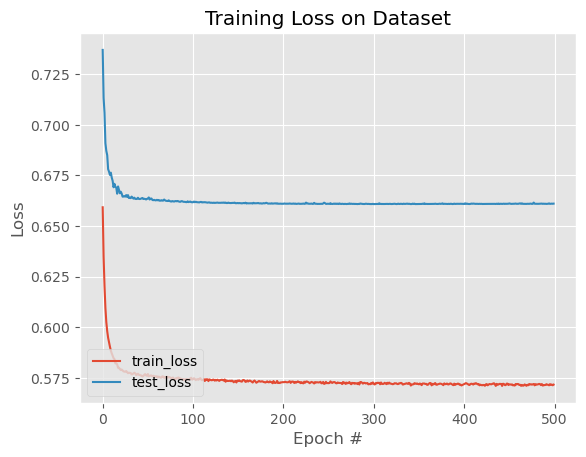

In [19]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(num_epochs)):
    # set the model in training mode
    unet.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
        # send the input to the device
        (x, y) = (x.to(device), y.to(device))
        # perform a forward pass and calculate the training loss
        pred = unet(x)
        loss = lossFunc(pred, y)
        # first, zero out any previously accumulated gradients, then
        # perform backpropagation, and then update model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()
        # add the loss to the total training loss so far
        totalTrainLoss += loss
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        unet.eval()
        # loop over the validation set
        for (x, y) in testLoader:
            # send the input to the device
            (x, y) = (x.to(device), y.to(device))
            # make the predictions and calculate the validation loss
            pred = unet(x)
            totalTestLoss += lossFunc(pred, y)
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, num_epochs))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(
        avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
    endTime - startTime))
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(plot_path)
# serialize the model to disk
torch.save(unet, model_path)

In [34]:
def prepare_plot(original_image: np.ndarray, original_mask: np.ndarray, predicted_mask: np.ndarray) -> None:
    """Prepares a plot with three subplots showing the original image, the ground truth mask, and the predicted mask."""
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
    axes[0].imshow(original_image)
    axes[0].grid(False)
    axes[0].set_title("Image")
    axes[1].imshow(original_mask)
    axes[1].grid(False)
    axes[1].set_title("Original Mask")
    axes[2].imshow(predicted_mask)
    axes[2].grid(False)
    axes[2].set_title("Predicted Mask")
    axes[3].hist(original_mask.flatten(), bins=20, label='original')
    axes[3].hist(predicted_mask.flatten(), bins=20, label='prediction')
    axes[3].legend()
    fig.tight_layout()
    plt.show()


def make_predictions(model: torch.nn.Module, image_path: str) -> None:
    """Takes a trained model and an image file path and generates a predicted mask."""
    model.eval()

    with torch.no_grad():
        
        # Load image and ground truth mask
        image = np.array(Image.open(image_path).convert("RGB"), dtype=np.float32) / 255.0
        original = image.copy()

        filename = os.path.split(image_path)[-1]
        ground_truth_path = os.path.join(mask_dataset_path, filename) 
        ground_truth_mask = np.array(Image.open(ground_truth_path).convert("L"), dtype=np.float32) / 255.0

        # Prepare input for model
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(device)

        # Generate predicted mask
        predicted_mask = model(image).squeeze()
        predicted_mask = torch.sigmoid(predicted_mask)
        predicted_mask = predicted_mask.cpu().numpy()

        # Visualize results
        prepare_plot(original, ground_truth_mask, predicted_mask)

In [29]:
# load the image paths in our testing file and randomly select 10 image paths
print("[INFO] loading up test image paths...")
imagePaths = open(test_paths).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=10)

[INFO] loading up test image paths...


In [30]:
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(model_path).to(device)

[INFO] load up model...


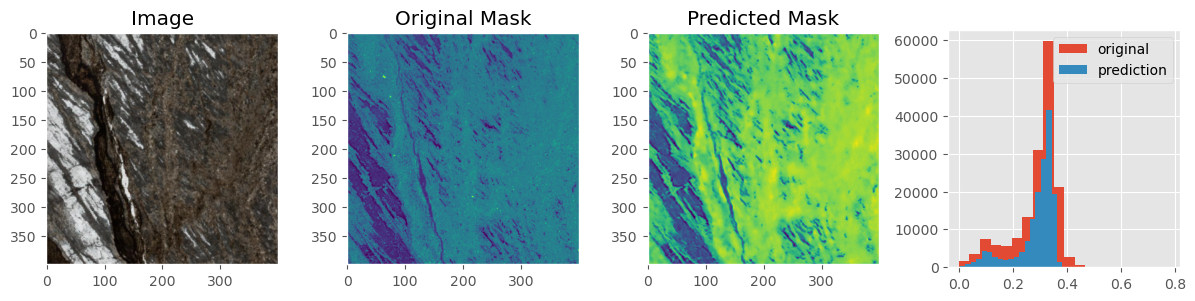

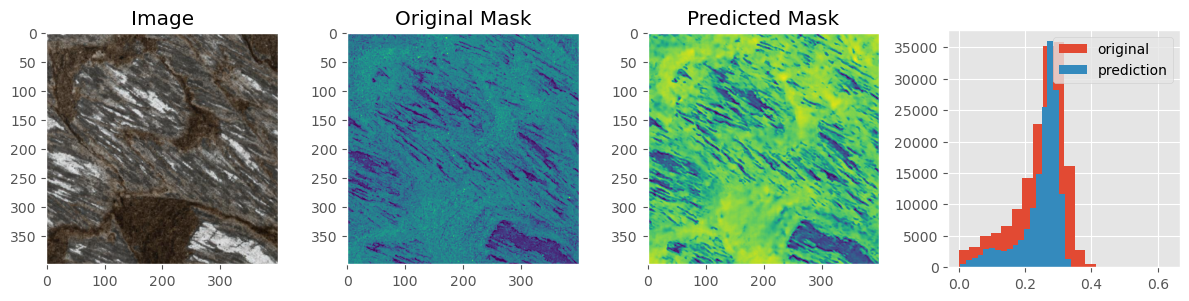

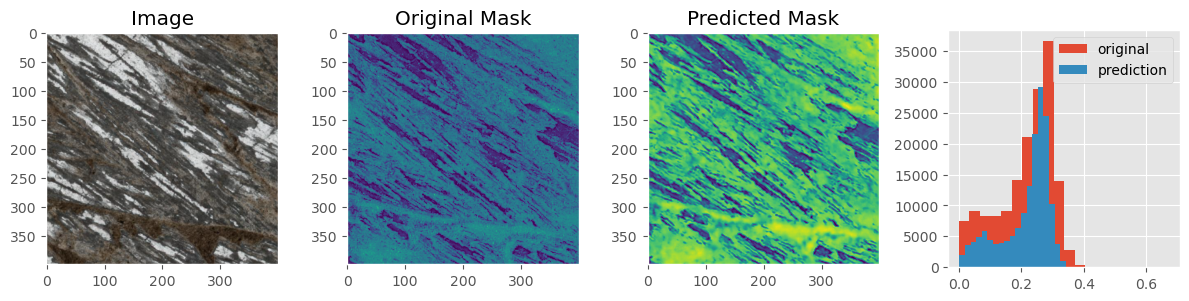

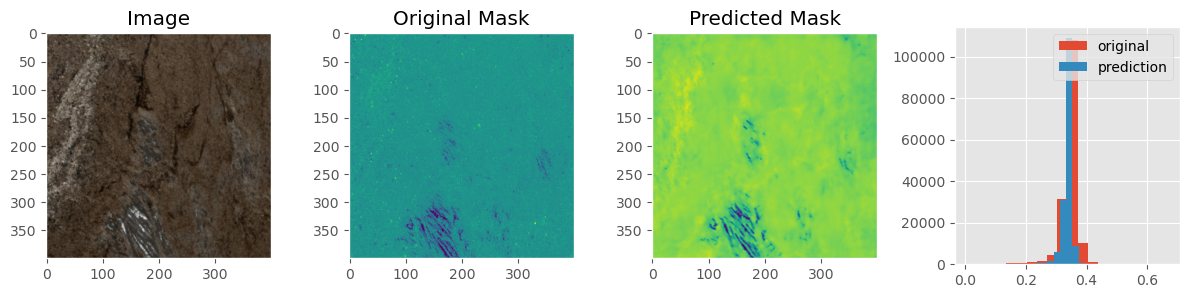

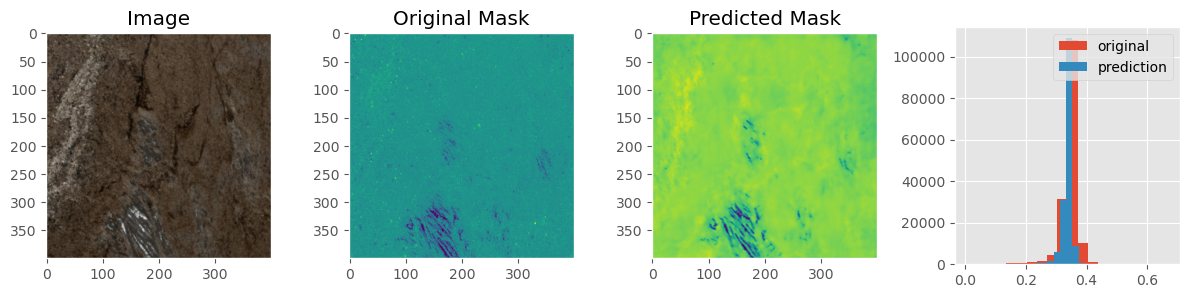

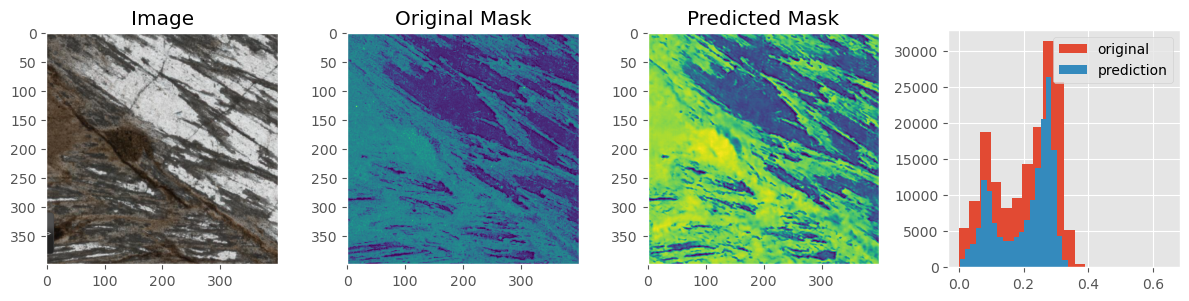

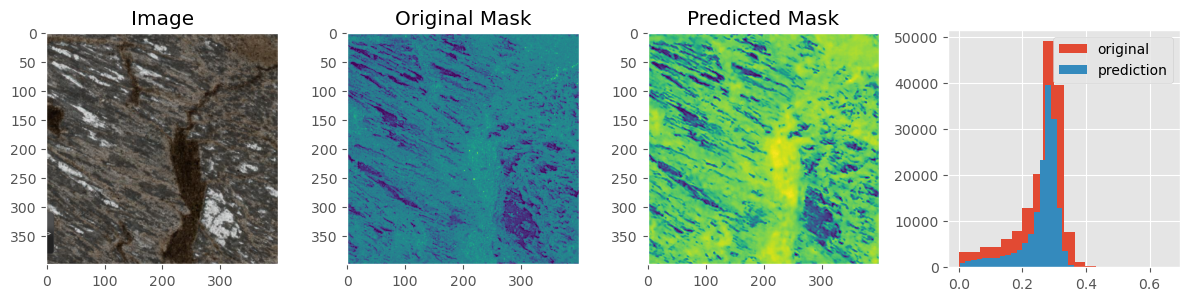

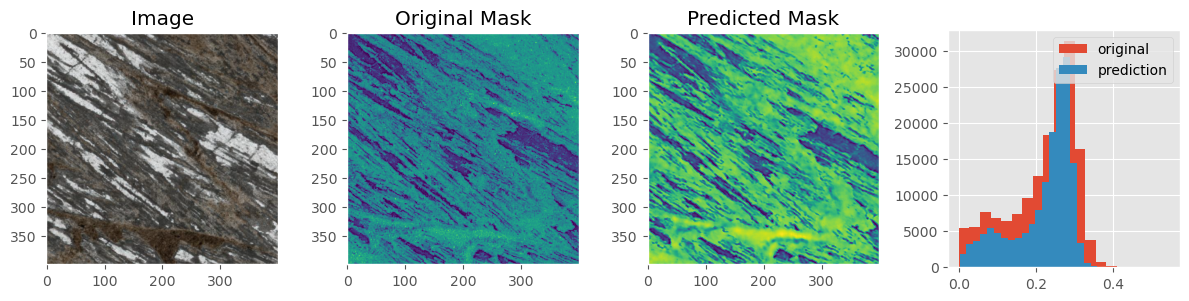

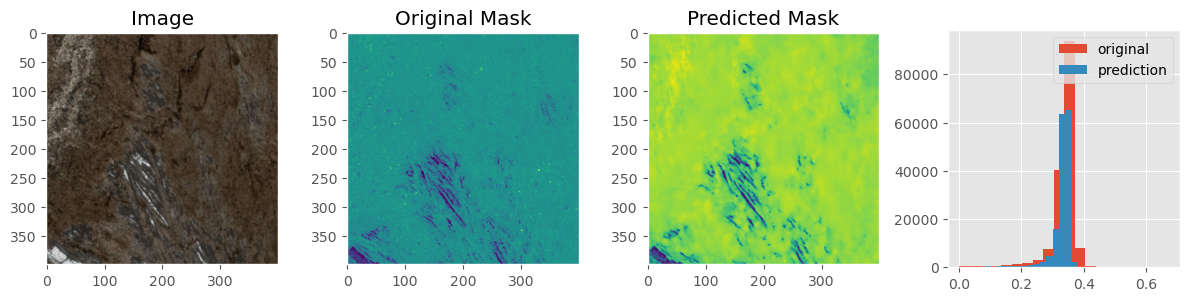

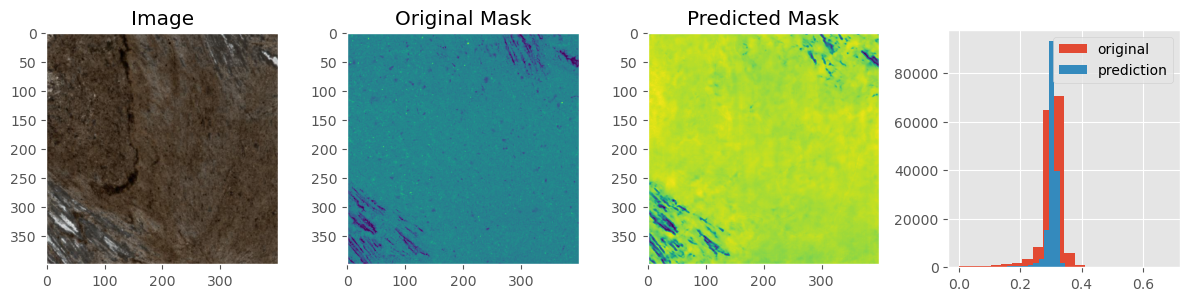

In [35]:
# iterate over the randomly selected test image paths
for path in imagePaths:
    # make predictions and visualize the results
    make_predictions(unet, path)